<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#개요" data-toc-modified-id="개요-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>개요</a></span><ul class="toc-item"><li><span><a href="#주제:-Allstate-Claims-Severity" data-toc-modified-id="주제:-Allstate-Claims-Severity-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>주제: Allstate Claims Severity</a></span></li><li><span><a href="#데이터-설명" data-toc-modified-id="데이터-설명-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>데이터 설명</a></span></li><li><span><a href="#함수-설정" data-toc-modified-id="함수-설정-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>함수 설정</a></span></li></ul></li><li><span><a href="#탐색적-분석(시각화-및-전처리)" data-toc-modified-id="탐색적-분석(시각화-및-전처리)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>탐색적 분석(시각화 및 전처리)</a></span><ul class="toc-item"><li><span><a href="#cat변수-시각화-및-전처리" data-toc-modified-id="cat변수-시각화-및-전처리-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>cat변수 시각화 및 전처리</a></span><ul class="toc-item"><li><span><a href="#cat변수-시각화" data-toc-modified-id="cat변수-시각화-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>cat변수 시각화</a></span></li><li><span><a href="#cat변수와-loss의-유의성(평균-차이)-검정" data-toc-modified-id="cat변수와-loss의-유의성(평균-차이)-검정-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>cat변수와 loss의 유의성(평균 차이) 검정</a></span></li><li><span><a href="#(변수내)-범주간-loss평균으로-수치화" data-toc-modified-id="(변수내)-범주간-loss평균으로-수치화-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>(변수내) 범주간 loss평균으로 수치화</a></span></li><li><span><a href="#one-hot-encoding으로-수치화" data-toc-modified-id="one-hot-encoding으로-수치화-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>one-hot encoding으로 수치화</a></span></li></ul></li><li><span><a href="#cont변수-시각화-및-전처리" data-toc-modified-id="cont변수-시각화-및-전처리-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>cont변수 시각화 및 전처리</a></span><ul class="toc-item"><li><span><a href="#선형회귀모델-p-value,-VIF-확인" data-toc-modified-id="선형회귀모델-p-value,-VIF-확인-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>선형회귀모델 p-value, VIF 확인</a></span></li></ul></li><li><span><a href="#loss-시각화" data-toc-modified-id="loss-시각화-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>loss 시각화</a></span></li></ul></li><li><span><a href="#모델링" data-toc-modified-id="모델링-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>모델링</a></span><ul class="toc-item"><li><span><a href="#랜덤포레스트" data-toc-modified-id="랜덤포레스트-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>랜덤포레스트</a></span></li></ul></li></ul></div>

# 개요
## 주제: Allstate Claims Severity
https://www.kaggle.com/c/allstate-claims-severity<br>
보험금 청구비용(loss) 예측 모델을 구축한다.

## 데이터 설명
미국의 개인 보험 회사 Allstate 계약(id)별 보험금 청구액(loss)관련 자료이다.<br>
컬럼명 cat1,2,3... cont1,2,3... 은 아래와 같이 의미한다.<br>
'cat' - categorical(명목형 변수)<br>
'cont' - continuous (연속형 변수)<br>

cat 데이터는 A,B,C...., LB,DC,CQ...등 유형을 나타내도록 변환되었고, cont 데이터는 0~1 소숫점으로 변환되어 주어진 상태이다.<br>
***변수가 익명화 되어 있어 변수 의미에 따른 분석 불가***

In [1]:
 # !pip install xgboost
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st

from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## 함수 설정

In [2]:
# Kmeans 관련 함수 설정

# kmeans로 확인 후 cont변수와 합쳐주는 DF 생성 함수
def kmeans_united(n, df) :
    # Kmenas로 변환
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(df)
    res = pd.Series(kmeans.labels_)
    tmp_X = pd.get_dummies(res, prefix="kmeans")
    
    # 기존 cont데이터와 병합
    new_X = pd.concat([tmp_X, X[cont_columns]], axis=1)
    
    return new_X

# kmeans Elbow 시각화
def kmeans_Elbow(df):
    cluster_range = range( 1, 20 )
    cluster_errors = []

    for num_clusters in cluster_range:
      clusters = KMeans( num_clusters )
      clusters.fit( df )
      cluster_errors.append( clusters.inertia_ )

    clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

    # Kmeans cluster_errors의 최적화 시각화
    plt.figure(figsize=(12,6), )
    plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o", )
    plt.title("The Elbow Method showing the optimal k")
    plt.show()
    
# kmeans 실행(클러스터 갯수 3,5,10,15,20,25 결과값 출력)
def kmeans_run(df) :
    reg_train_result = []
    reg_test_result = []
    kmeans_n = []
    for cluster in [3,5,10,15,20,30,40]:
        # Kmeans 실행
        X_kmeans = kmeans_united(cluster, df) 

        # 회귀분석 실행
        X_train, X_test, Y_train, Y_test = train_test_split(X_kmeans, y, test_size=0.3, random_state=5) 
        lm = LinearRegression()
        lm.fit(X_train,Y_train)
        Y_pred_train = lm.predict(X_train)
        Y_pred_test = lm.predict(X_test)

        # 결과저장
        kmeans_n.append(f'Kmeans_{cluster}')
        reg_train_result.append(str(np.sqrt(metrics.mean_squared_error(Y_train, Y_pred_train))))
        reg_test_result.append(str(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test))))
    
    list_result = list(zip(kmeans_n, reg_train_result, reg_test_result))
    result = pd.DataFrame(list_result, columns = ['kmeans_n', 'reg_train_result','reg_test_result'])
    print(result)

In [110]:
# PCA 관련 함수 설정

# pca로 차원축소 후 cont변수와 합쳐주는 DF 생성 함수
def pca_united(n, df) :
    # pca로 변환
    pca = PCA(n_components = n)
    X_pca = pca.fit_transform(df)
    
    # 기존 cont데이터와 병합
    new_X = pd.concat([pd.DataFrame(X_pca), X[cont_columns]], axis=1)
    
    return new_X

# pca 실행(주성분 갯수 3,5,10,15,20,25,30,35,40,45 결과값 출력)
def pca_run(df) :
    reg_train_result = []
    reg_test_result = []
    pca_n = []
    for cluster in [3,5,10,15,20,25,30,35,40,45]:
        # Kmeans 실행
        X_pca = pca_united(cluster, df) 

        # 회귀분석 실행
        X_train, X_test, Y_train, Y_test = train_test_split(X_pca, y, test_size=0.3, random_state=5) 
        lm = LinearRegression()
        lm.fit(X_train,Y_train)
        Y_pred_train = lm.predict(X_train)
        Y_pred_test = lm.predict(X_test)

        # 결과저장
        pca_n.append(f'pca_{cluster}')
        reg_train_result.append(str(np.sqrt(metrics.mean_squared_error(Y_train, Y_pred_train))))
        reg_test_result.append(str(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test))))

    list_result = list(zip(pca_n, reg_train_result, reg_test_result))
    result = pd.DataFrame(list_result, columns = ['pca_n', 'reg_train_result','reg_test_result'])
    print(result)

In [4]:
# stats 모듈 선형회귀 관련 함수

# 선형회귀모델 summary와 FMSE 출력
def st_Reg(X_train, X_test, Y_train, Y_test) :
    X_train = sm.add_constant(X_train) # 상수항 생성
    
    # 모델 학습
    model = sm.OLS(Y_train, X_train).fit()
    print_model = model.summary()
    X_test = sm.add_constant(X_test)
    
    # 회귀모형 predict
    predictions = model.predict(X_test)
    rmse = sm.tools.eval_measures.rmse(predictions, Y_test, axis=0)
    
    # 다중공선성 검정(vif)
    tmp_vif = pd.DataFrame()
    tmp_vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    tmp_vif = tmp_vif.T
    tmp_vif.columns = X_train.columns
    
    print(print_model)
    print('---------------------------------------------------------------------------------')
    print(f'RMSE : {rmse}')
    print('---------------------------------------------------------------------------------')
    print(tmp_vif)

In [115]:
# 범주간 평균차가(예:A의 loss평균 - B의 loss평균) n이상인 변수명을 리스트로 반환
def maxMinusMin(n) :
    maxMinusMinList = []
    for col in X_cat.drop(columns='loss').columns :
        tmpMax = max(X_cat[col])
        tmpMin = min(X_cat[col])

        if tmpMax - tmpMin > n :
            maxMinusMinList.append(col)
            #print(f'{col}의 최대값-최소값 : {tmpMax - tmpMin}')
        #else :
            #print(f'{col}의 최대값-최소값 : {tmpMax - tmpMin} <- 변수 삭제')
    return maxMinusMinList


# 탐색적 분석(시각화 및 전처리)

In [5]:
train = pd.read_csv('train.csv')
train.shape

(188318, 132)

In [6]:
X = train.iloc[:,1:-1]
y = train.loss

X, X_validation, y, y_validation = train_test_split(X, y, test_size=0.3, random_state=5)

# index 초기화
X = X.reset_index().drop(columns='index')
y = y.reset_index().drop(columns='index')


# cout와 cat 변수명 리스트로 담기
cont_columns = []
cat_columns = []

for i in X.columns:
    if X[i].dtype == 'float':
        cont_columns.append(i)
    elif X[i].dtype == 'object':
        cat_columns.append(i)

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131822 entries, 0 to 131821
Columns: 130 entries, cat1 to cont14
dtypes: float64(14), object(116)
memory usage: 130.7+ MB


In [20]:
X.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,D,E,D,E,A,S,I,A,A,A,D,E,I,J,I,BI,CS,A,AD,L,J,N,DD,0.299256,0.681761,0.549770,0.730249,0.388783,0.344288,0.354907,0.95332,0.33051,0.31480,0.291268,0.286079,0.486670,0.792863
1,A,B,B,B,A,A,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,B,A,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,B,B,B,C,B,D,D,A,A,B,A,A,D,B,C,E,A,D,T,N,C,A,A,I,E,F,J,K,BI,EB,K,AN,S,A,P,LB,0.640095,0.422197,0.174588,0.789639,0.718531,0.825463,0.605161,0.66201,0.64681,0.68039,0.569745,0.576121,0.770888,0.283904
2,A,B,A,A,A,A,A,A,B,B,B,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,B,D,C,B,B,B,A,A,A,A,A,D,B,D,E,A,A,P,L,M,A,A,G,E,G,E,B,AB,CS,A,AV,K,A,J,HJ,0.629339,0.358319,0.215772,0.838840,0.281143,0.430536,0.407700,0.36083,0.46853,0.52221,0.377724,0.369858,0.321548,0.305191
3,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,B,D,E,C,A,P,I,A,A,A,F,E,H,F,B,AB,EG,G,AN,K,A,K,HA,0.493164,0.299102,0.246911,0.821574,0.281143,0.331398,0.320920,0.39455,0.39648,0.32935,0.341813,0.335036,0.290422,0.275592
4,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,D,C,E,E,A,K,B,G,A,A,F,F,J,I,A,BI,CL,E,E,BN,A,L,GN,0.181508,0.199504,0.377180,0.318422,0.732367,0.250739,0.272300,0.32843,0.24958,0.27777,0.355987,0.348775,0.310026,0.821333


In [21]:
X.describe(include = ['object'])

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
count,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822,131822
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,7,7,8,7,5,7,5,8,7,5,16,15,16,9,13,17,20,17,20,11,79,127,16,51,59,18,22,306
top,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,D,C,E,C,A,P,F,A,A,A,E,E,G,F,B,BI,CL,A,E,BM,A,K,HK
freq,99058,74844,124552,89821,86608,92256,128670,124122,79299,112124,117733,111855,118124,130234,131802,127263,130868,131129,130576,131681,131510,131790,110173,127381,118878,124003,117798,126728,129242,129284,128146,130983,131123,131404,131668,109348,116021,118509,128363,126097,126835,130629,128878,120815,128822,131201,131321,131628,125415,96358,130957,125736,121113,128659,131716,131688,129752,131650,131611,131510,131310,131790,131771,131791,130270,126009,131332,131726,131606,131807,124978,82739,107978,129287,108047,126928,131271,130605,107091,96262,108098,103285,99103,108370,130227,72589,116894,118314,128670,124552,77693,87386,105211,85188,61379,121982,54739,73722,55536,29918,74844,124122,86608,29988,53515,33052,33054,45820,107153,17788,89821,17568,18260,92256,30734,14808


In [22]:
X.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
count,131822.000000,131822.000000,131822.000000,131822.000000,131822.000000,131822.000000,131822.000000,131822.000000,131822.000000,131822.000000,131822.000000,131822.000000,131822.000000,131822.000000
mean,0.493899,0.507668,0.499063,0.491568,0.487322,0.491328,0.485184,0.486382,0.485567,0.498481,0.493757,0.493406,0.493536,0.495861
std,0.187392,0.207065,0.202315,0.211233,0.208904,0.205355,0.178432,0.199372,0.181390,0.185832,0.209608,0.209335,0.212867,0.222481
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722
25%,0.347403,0.358319,0.336963,0.327354,0.281143,0.336105,0.351074,0.317960,0.358970,0.364580,0.314313,0.318249,0.315758,0.294758
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.466720,0.457203,0.462286,0.363547,0.408085
75%,0.623912,0.681761,0.634224,0.652072,0.635304,0.655553,0.591045,0.623580,0.568890,0.614590,0.678924,0.675759,0.689974,0.724629
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848


## cat변수 시각화 및 전처리
### cat변수 시각화

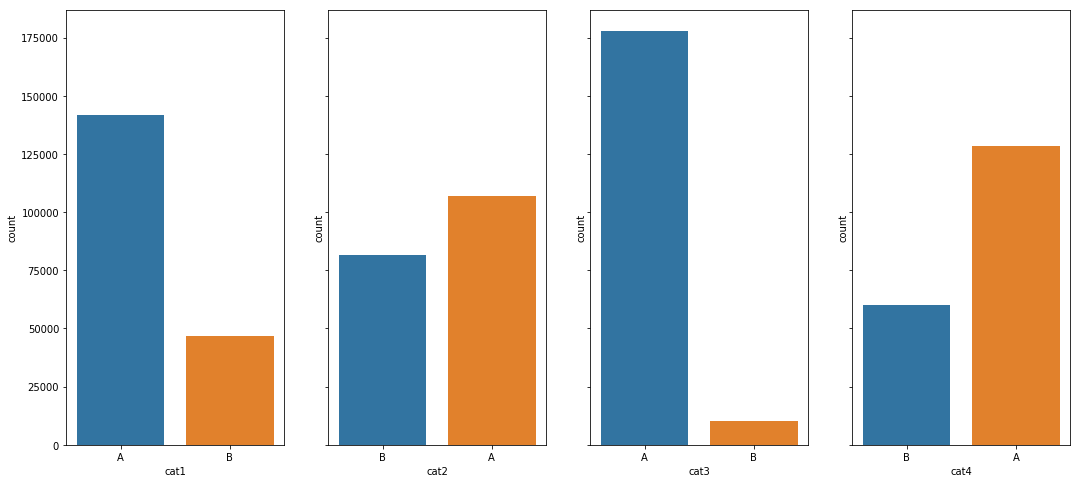

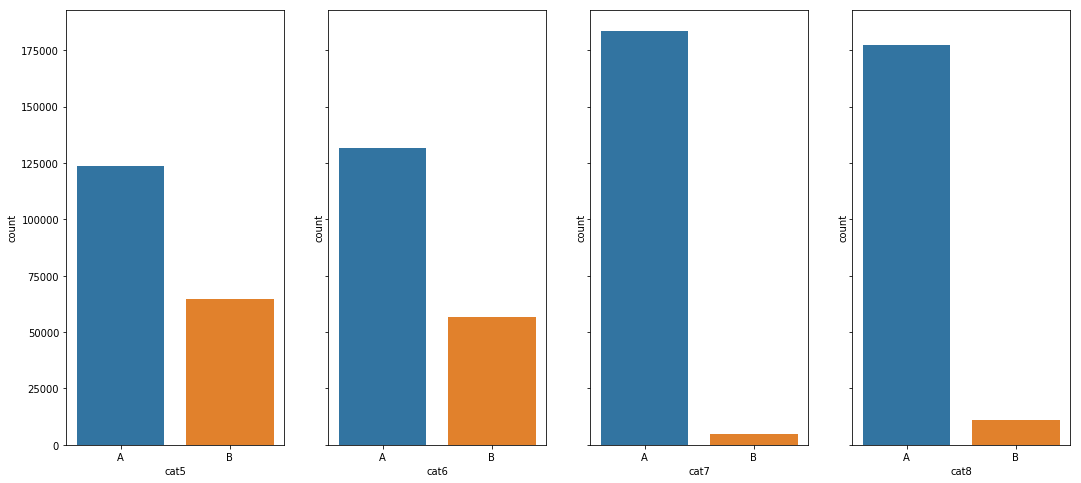

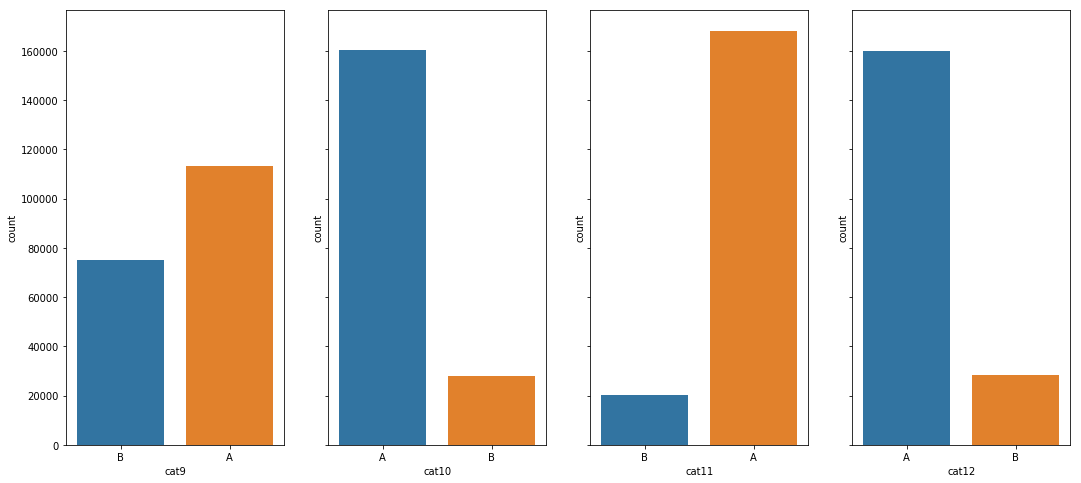

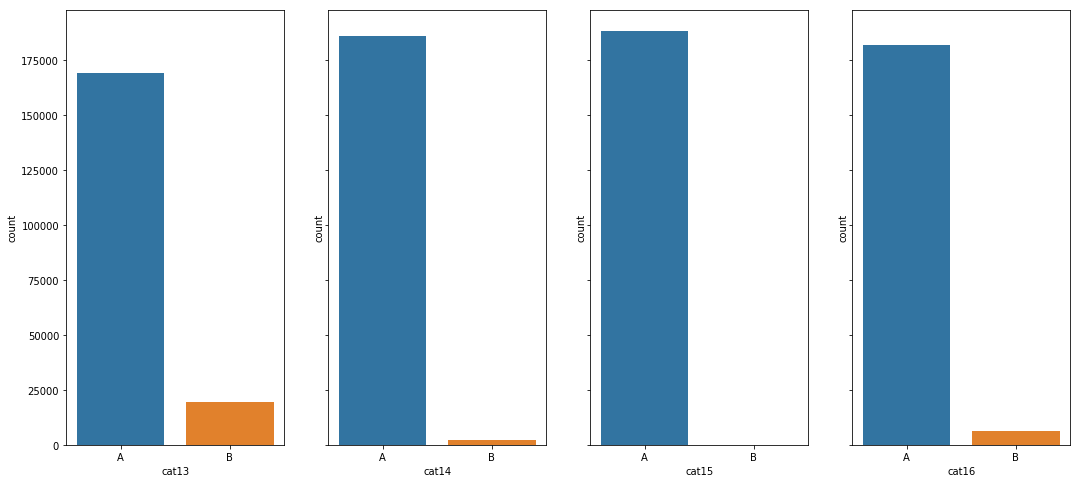

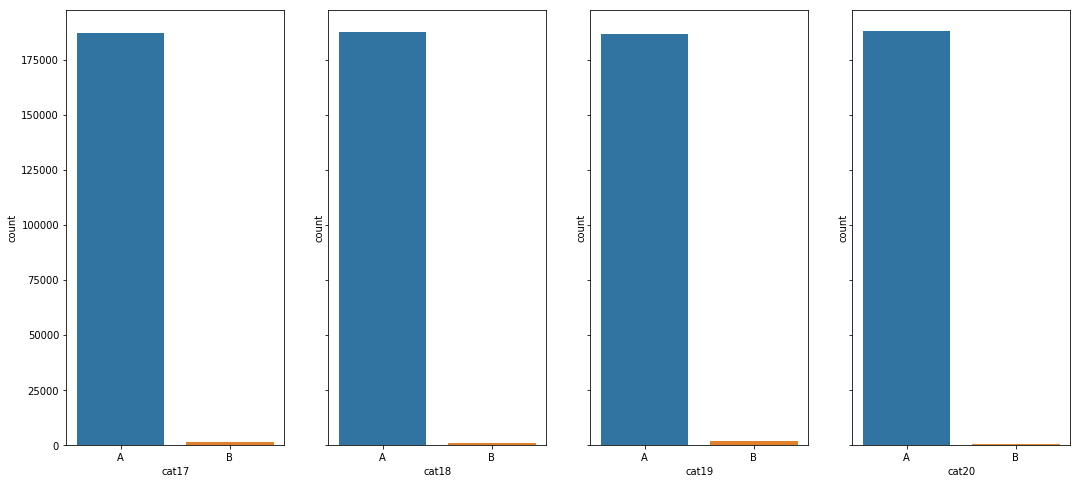

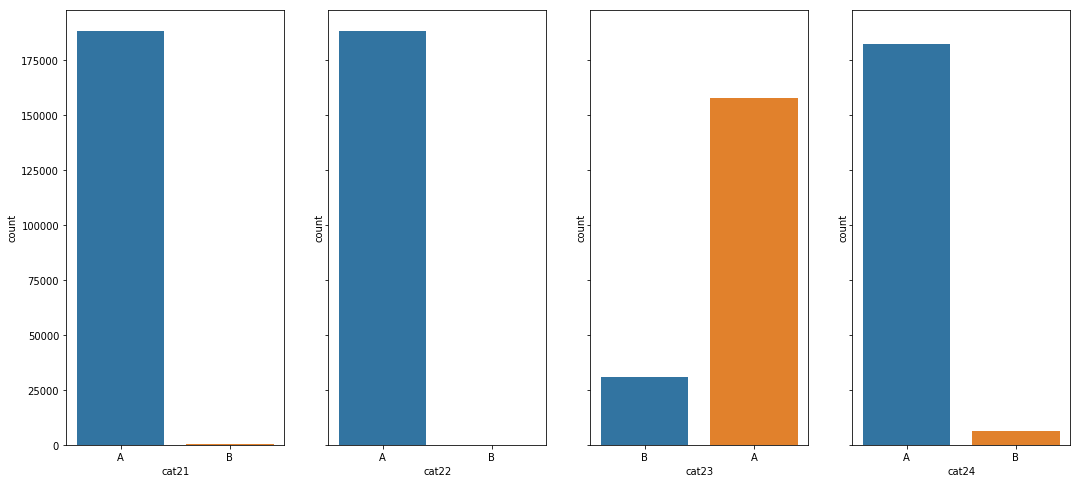

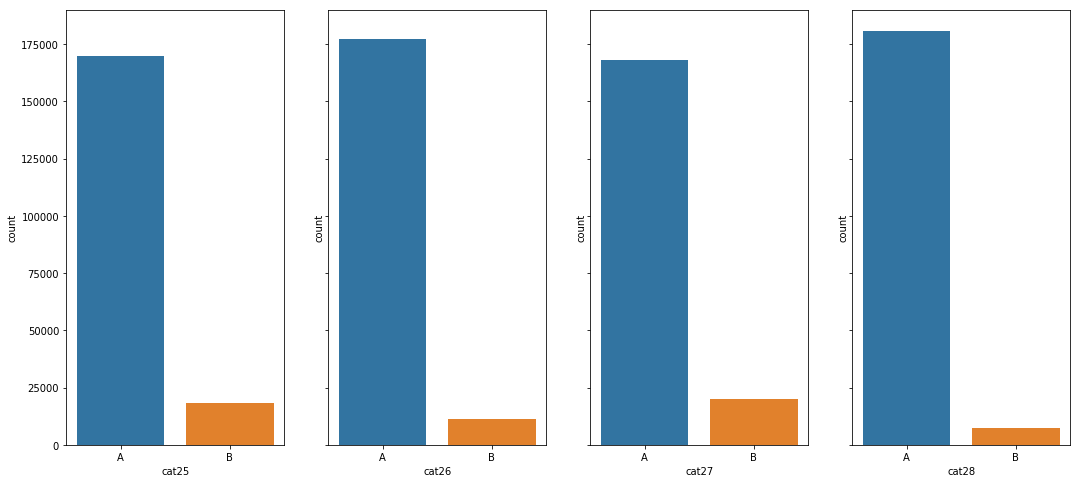

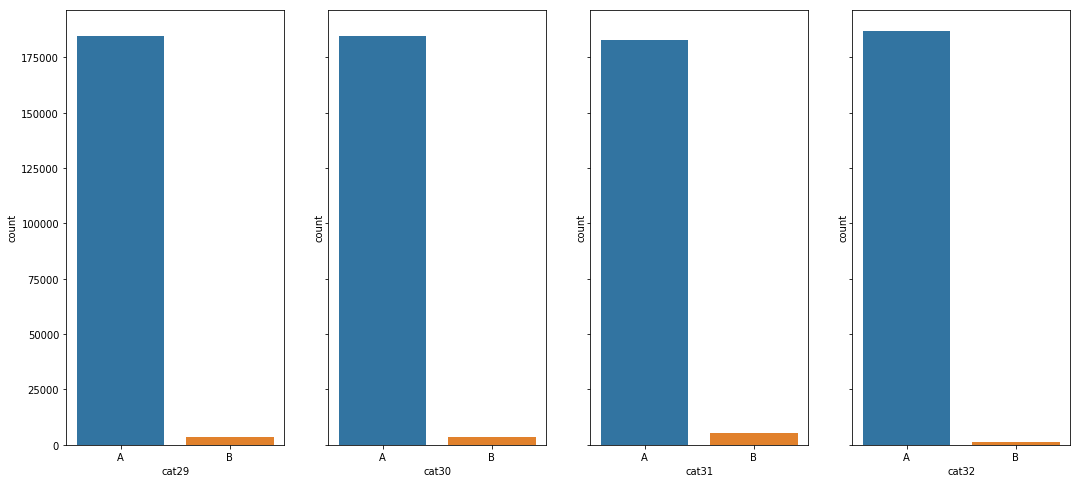

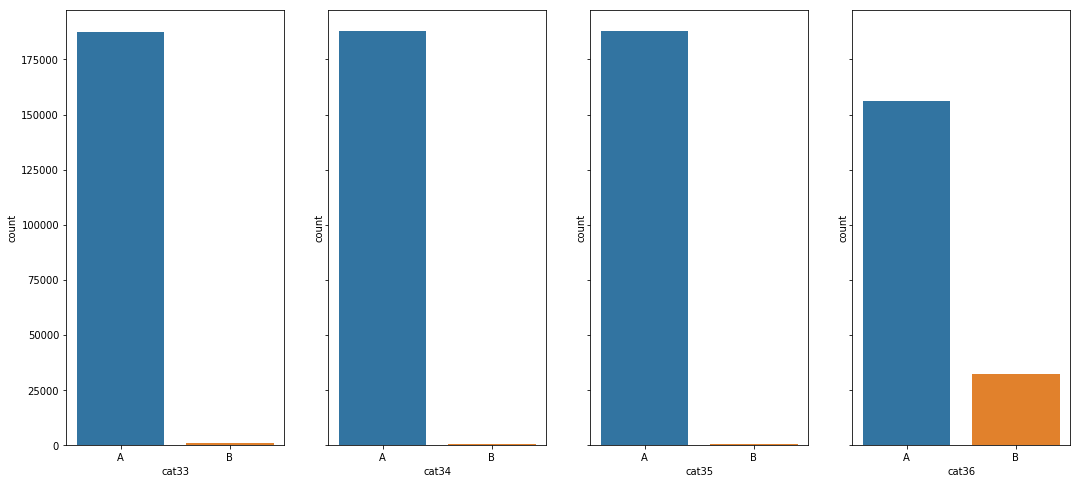

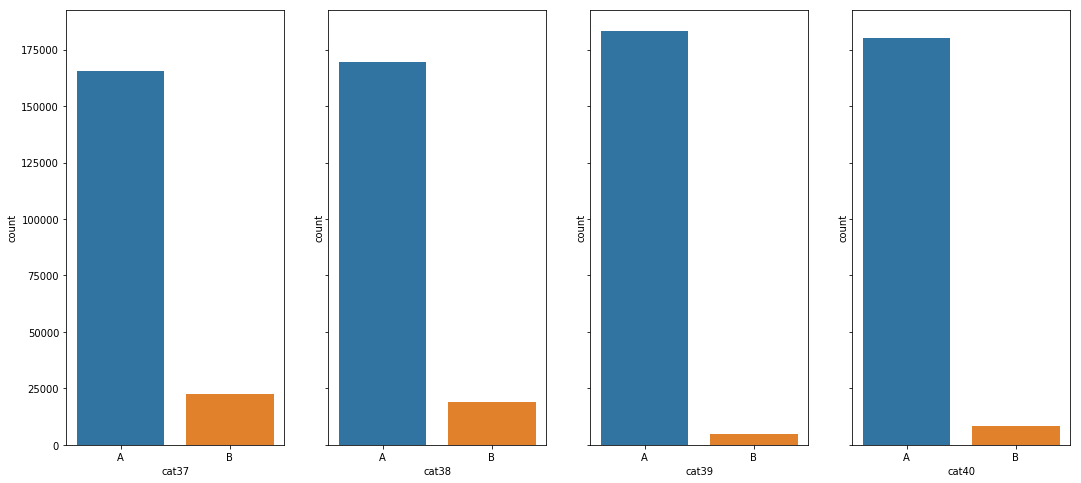

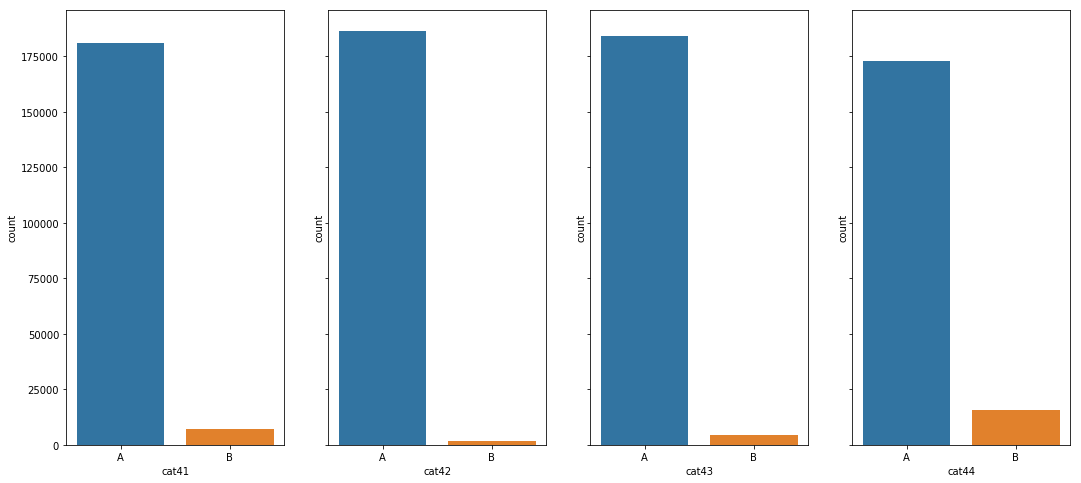

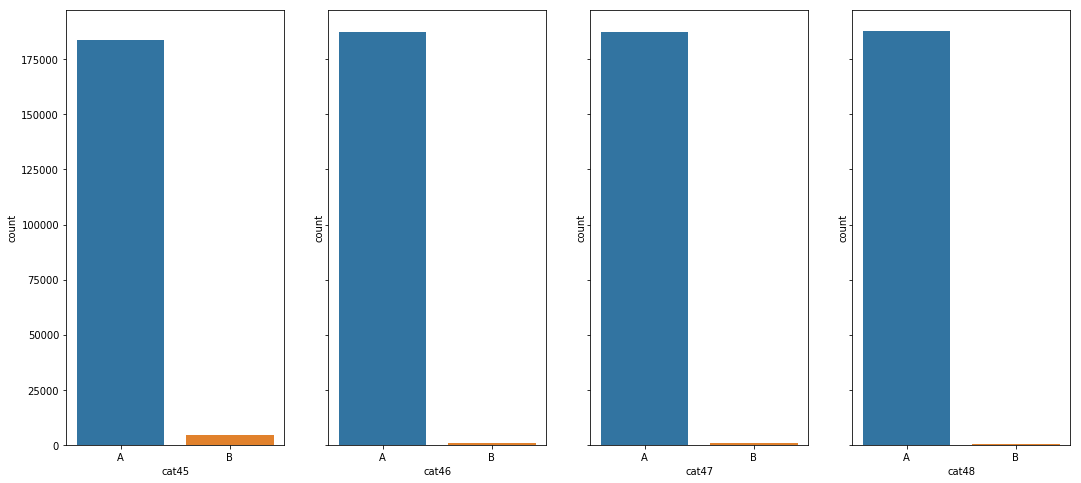

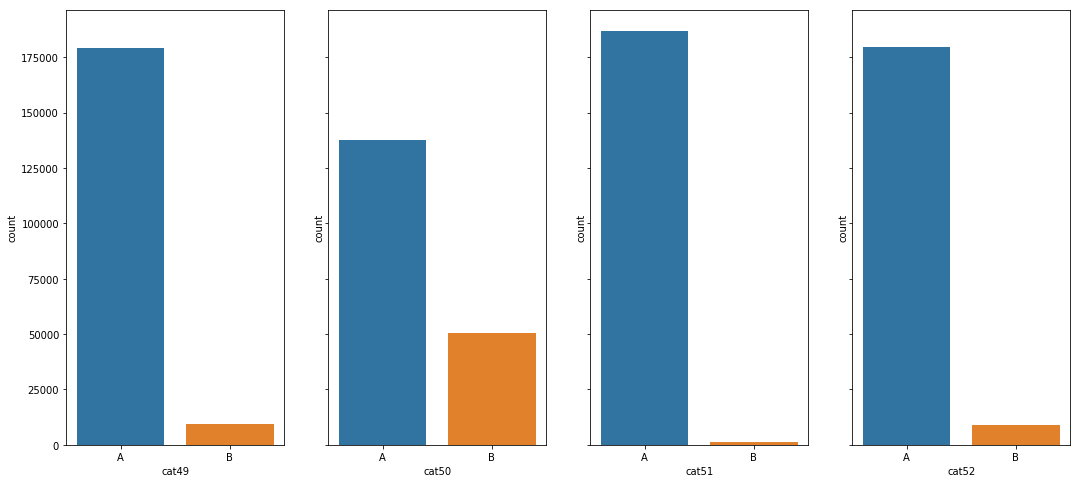

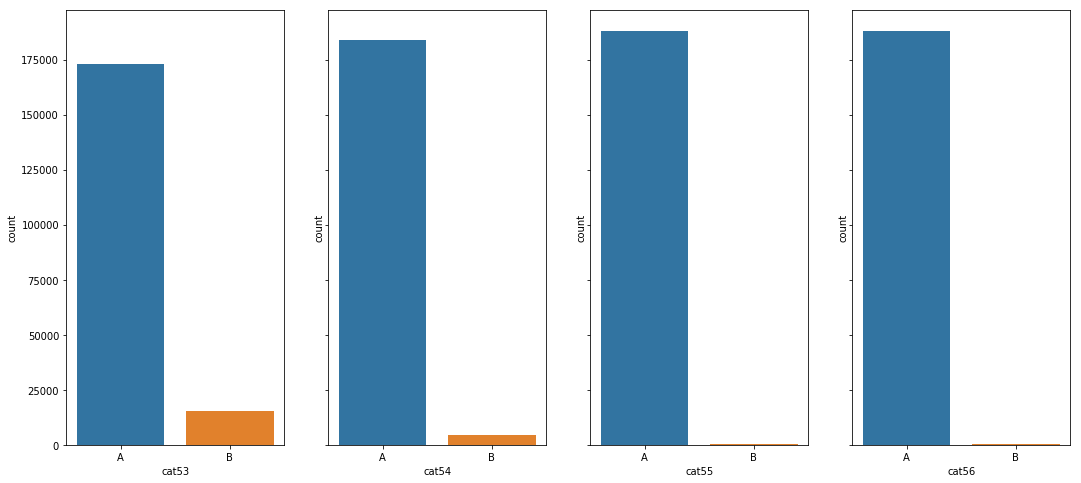

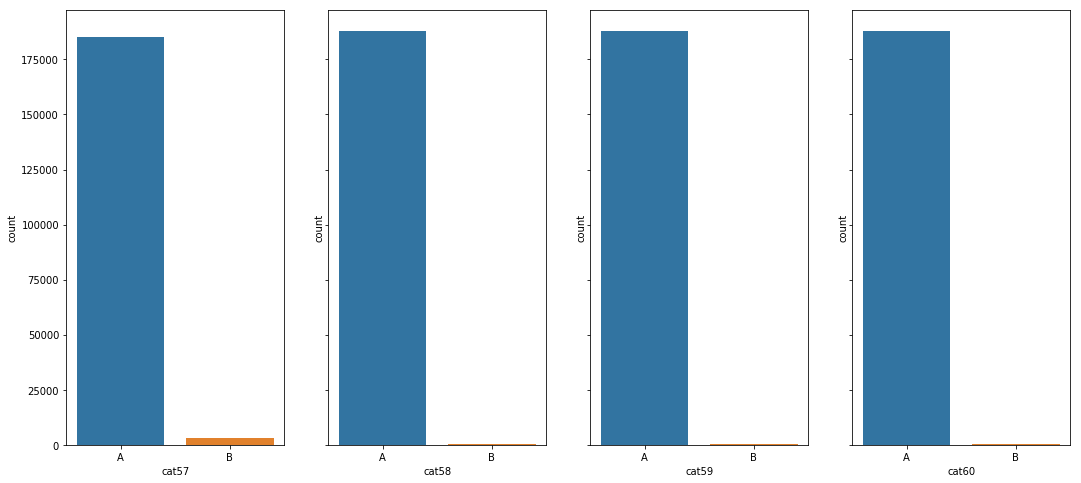

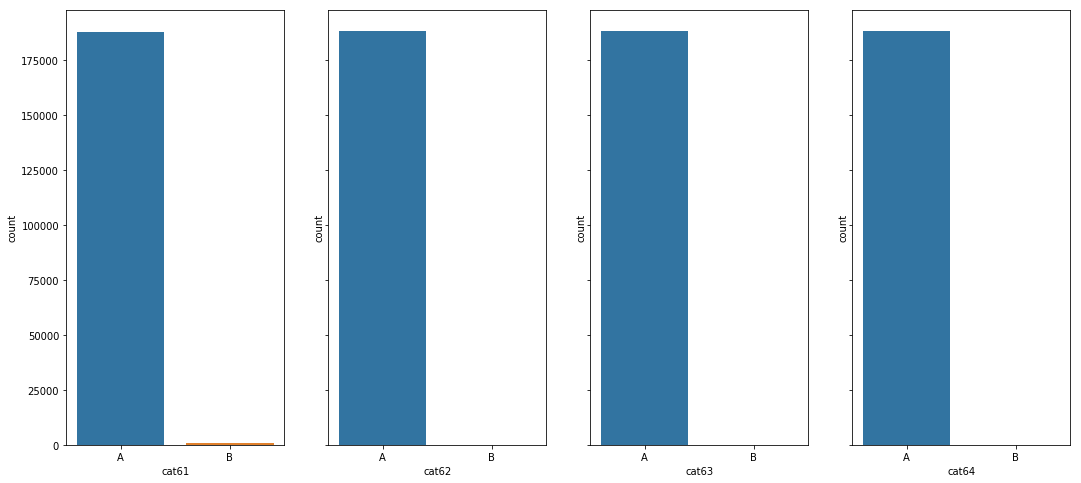

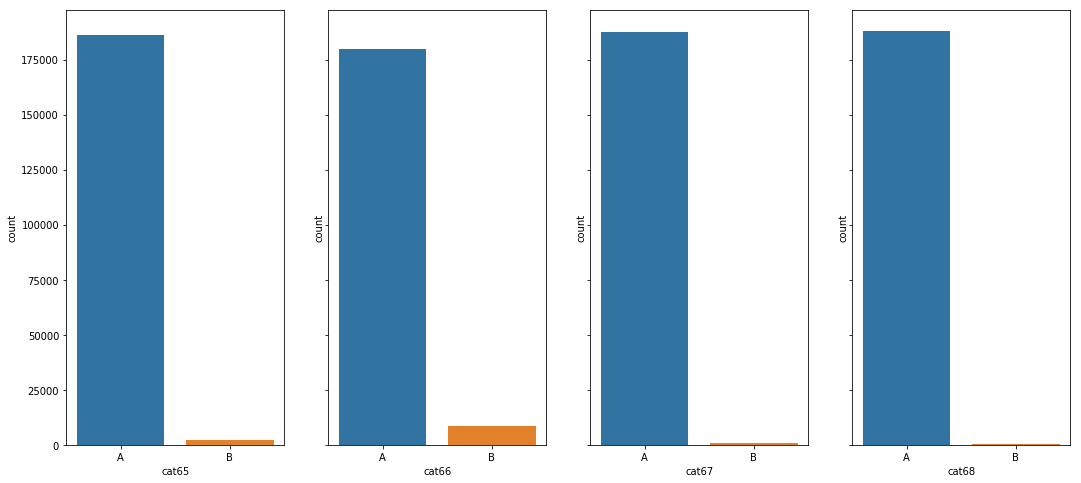

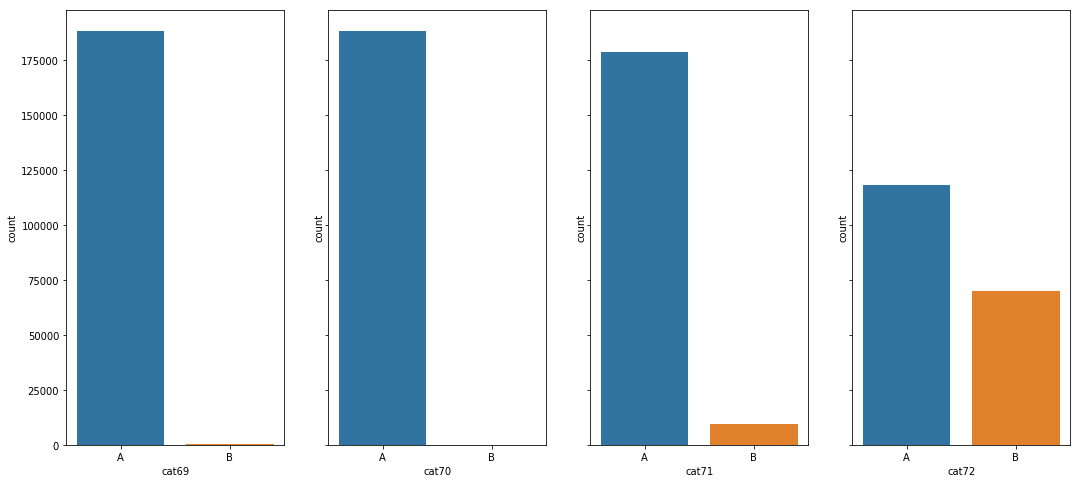

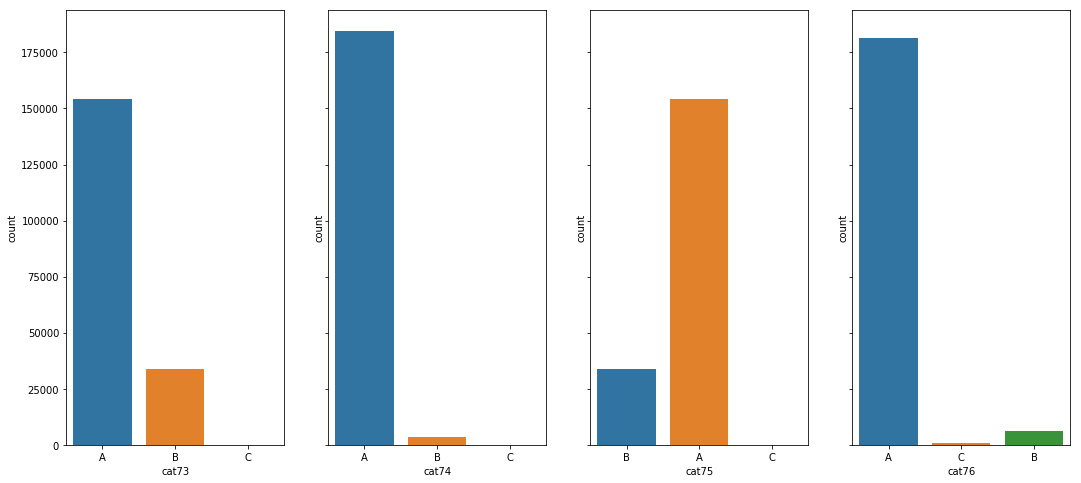

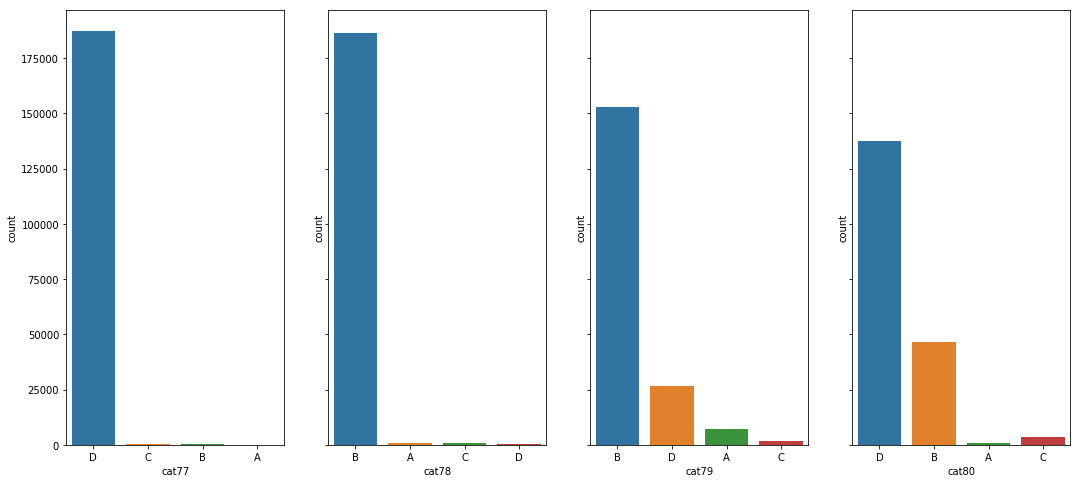

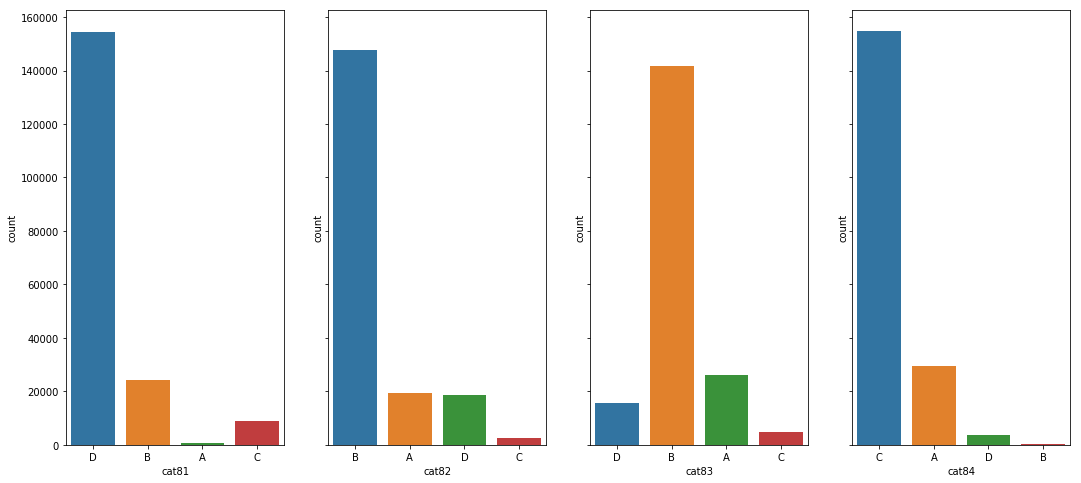

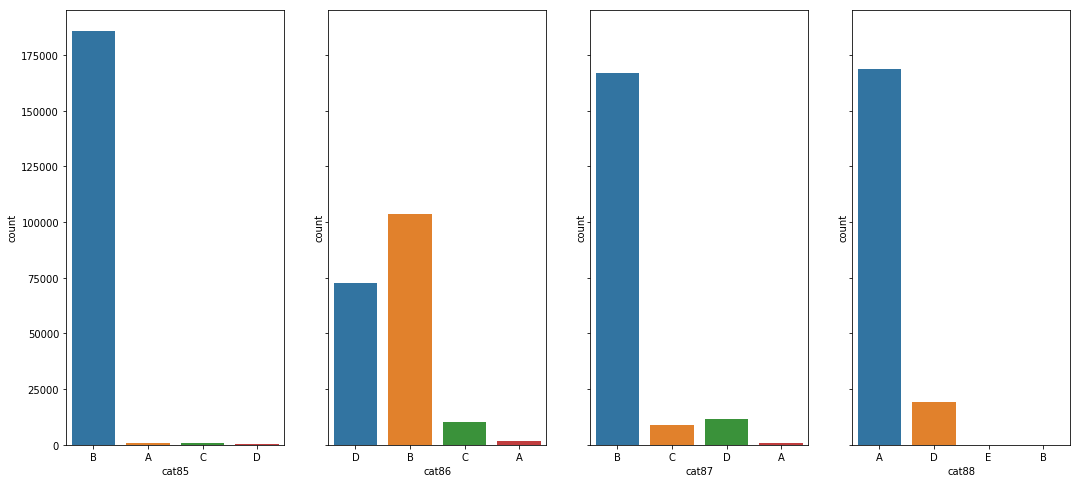

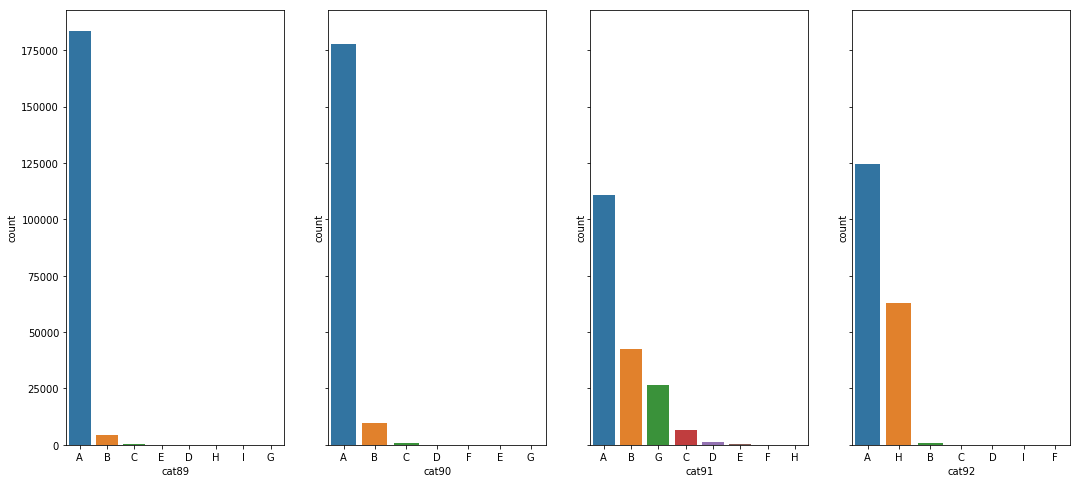

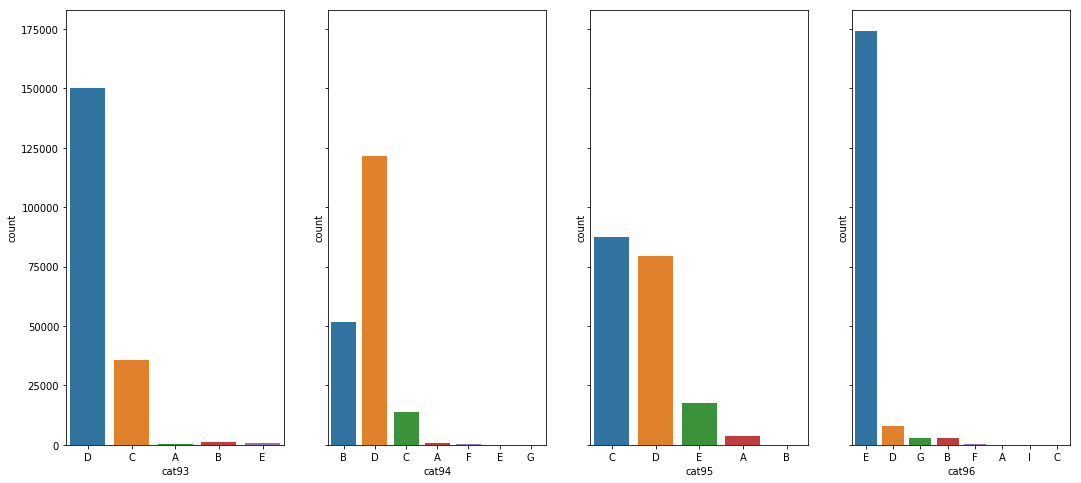

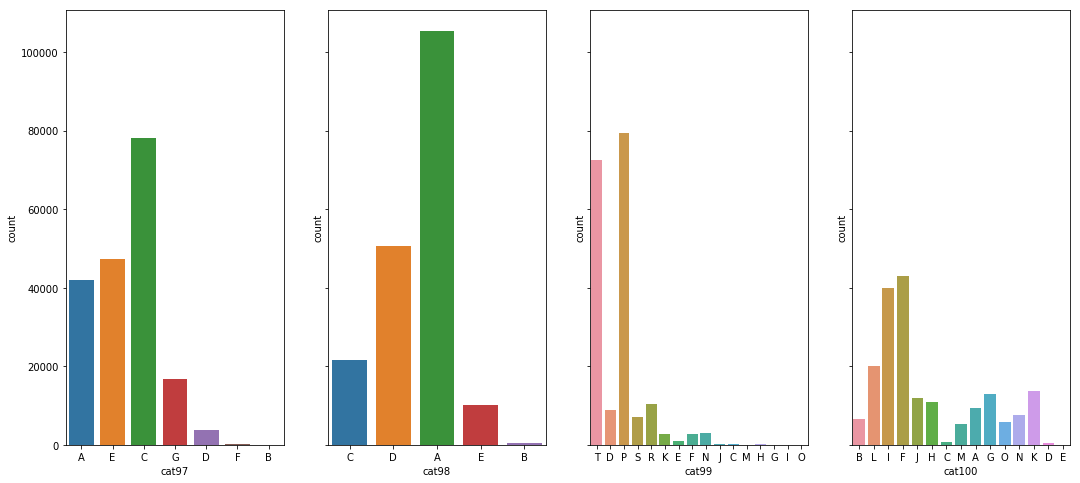

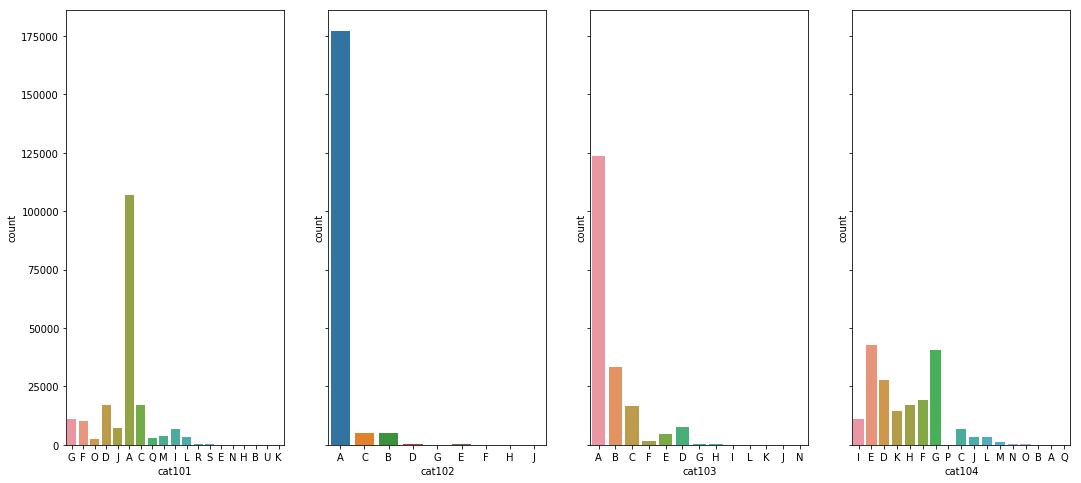

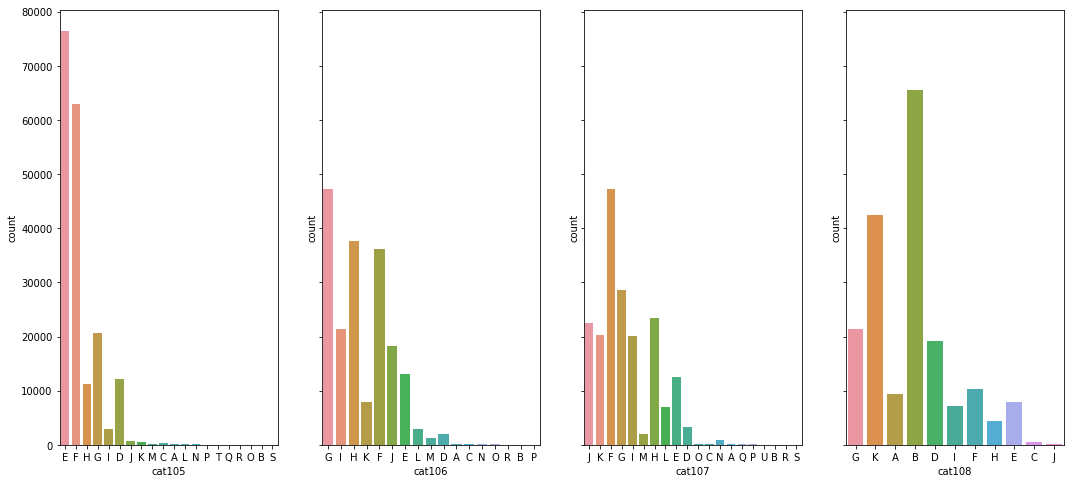

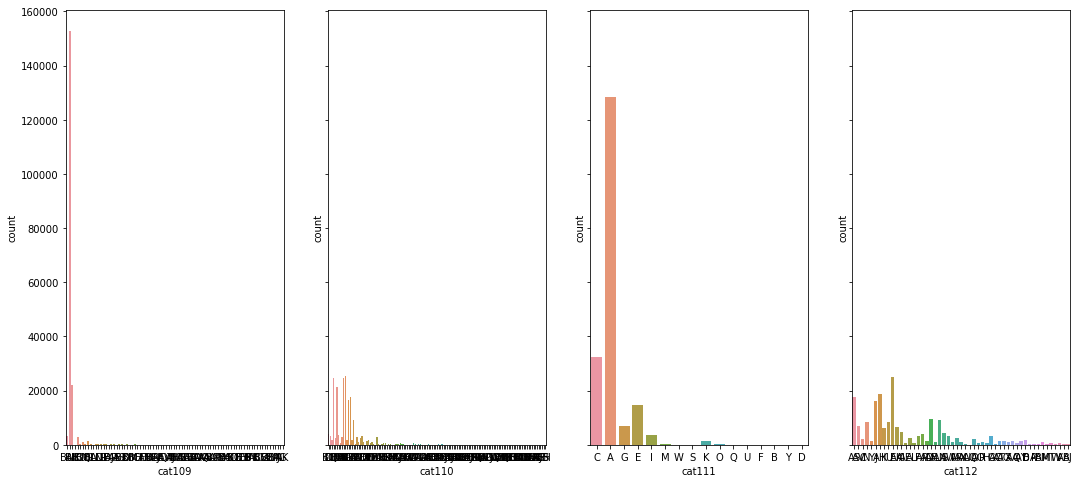

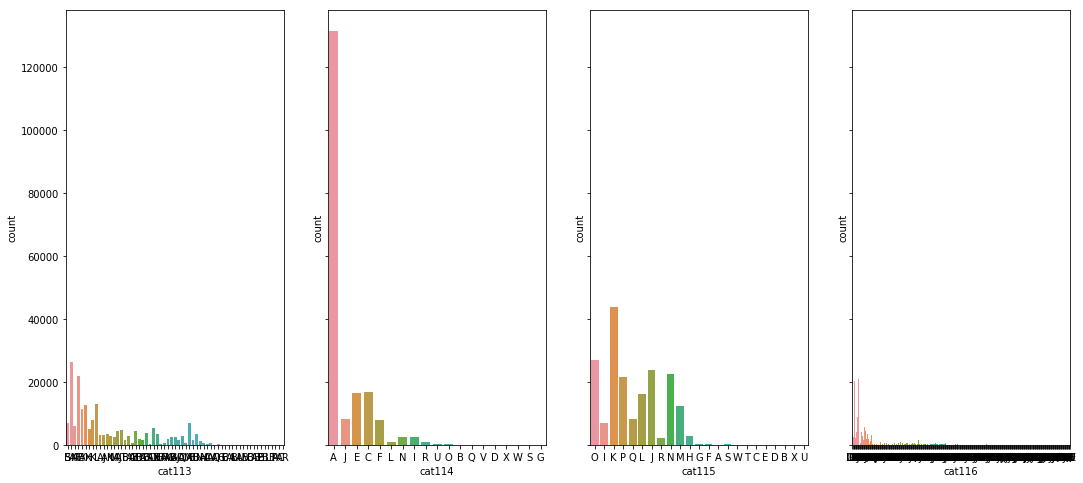

In [15]:
cols = X[cat_columns].columns

# 29x4 형태로 시각화

n_cols = 4
n_rows = 29
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(18, 8))
    for j in range(n_cols):
        sns.countplot(x=cols[i*n_cols+j], data=train, ax=ax[j])

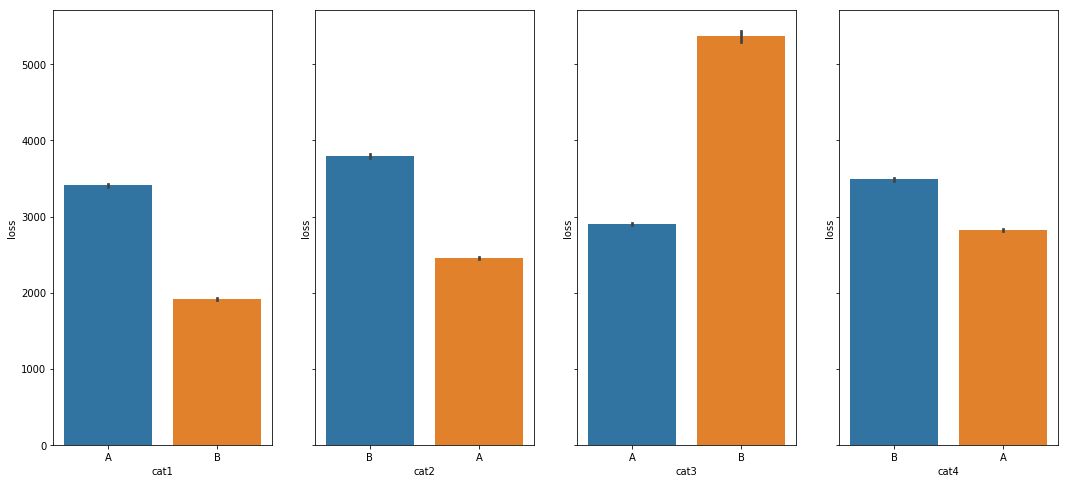

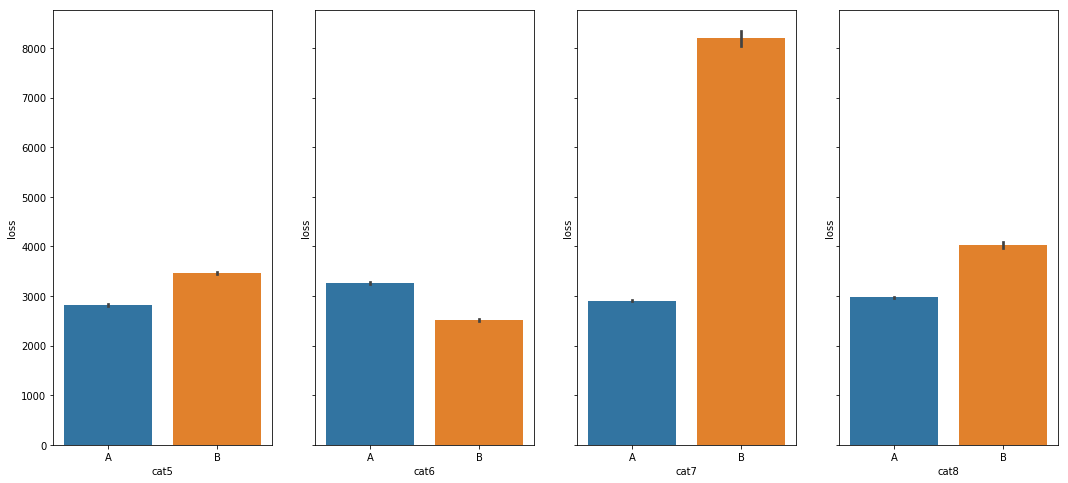

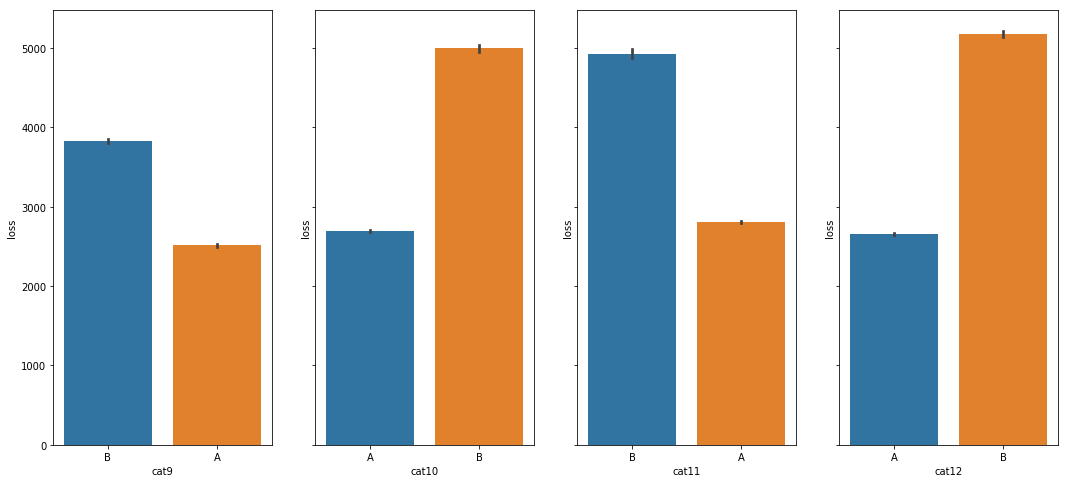

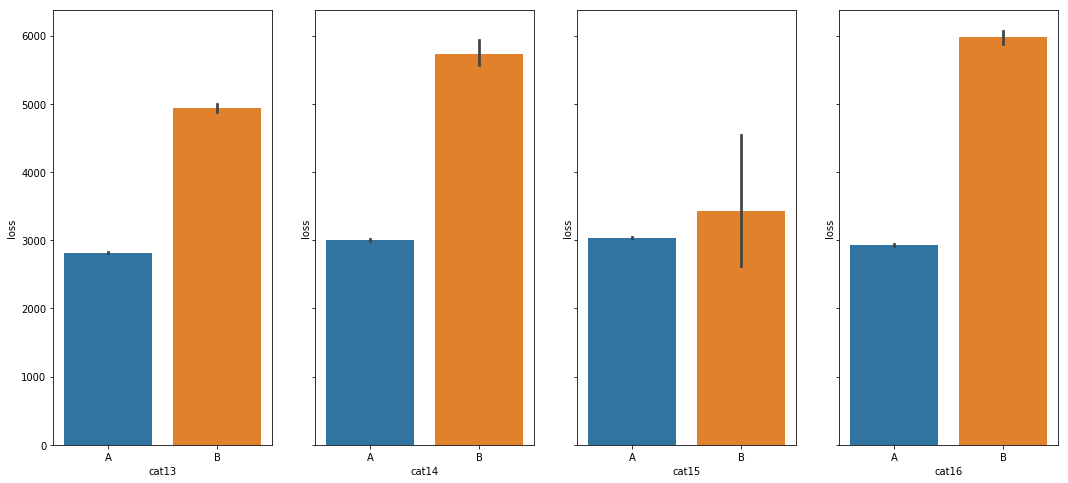

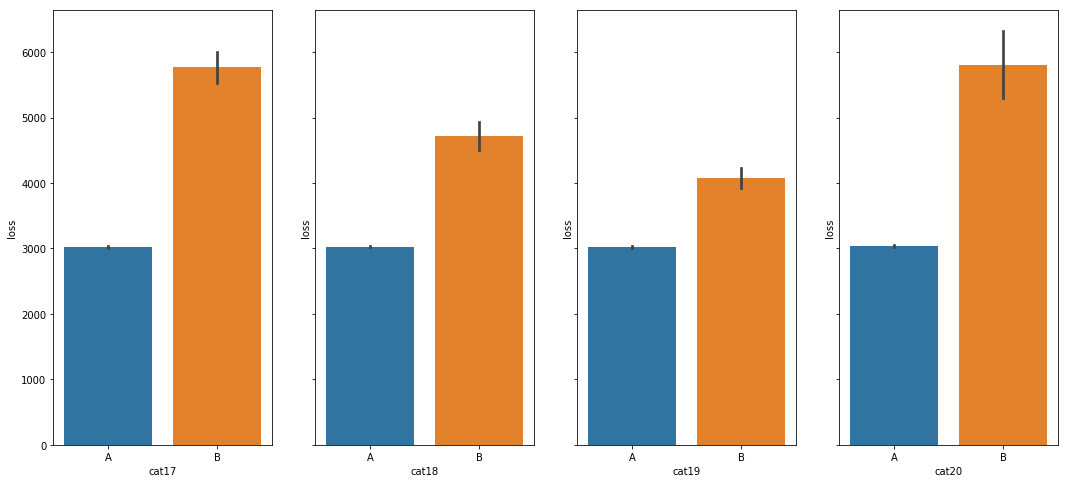

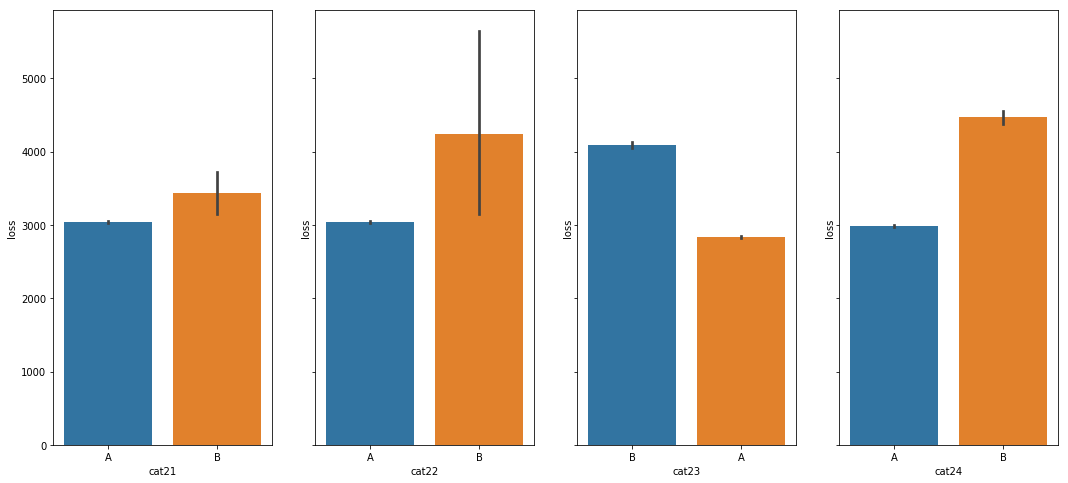

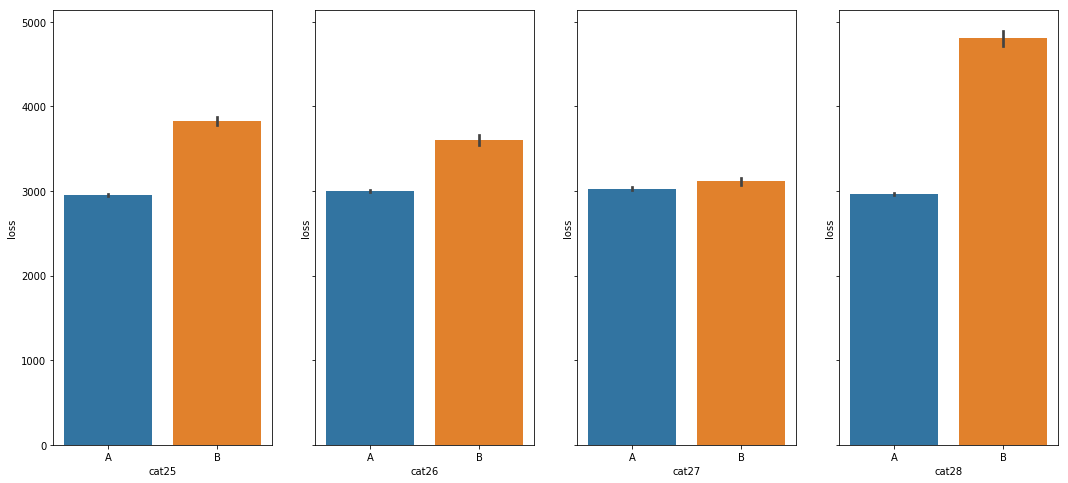

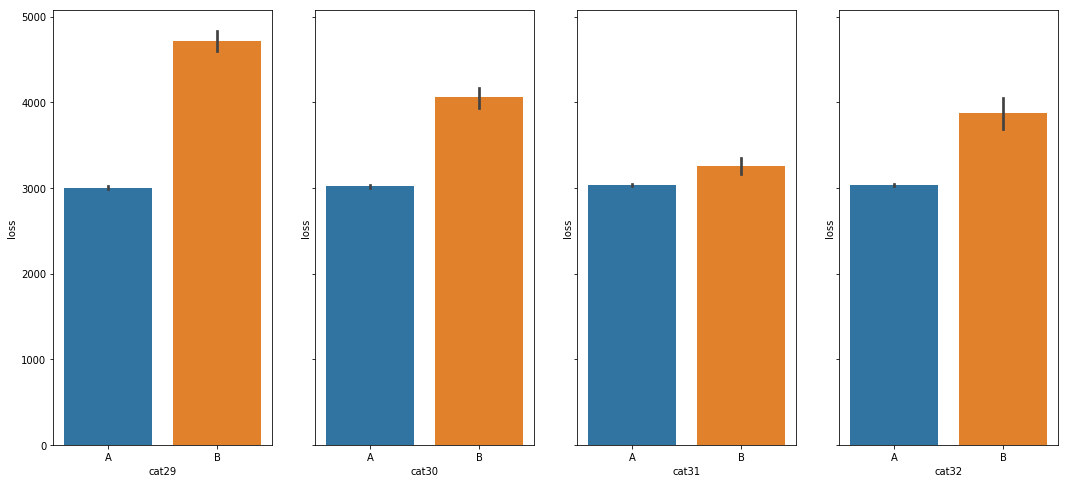

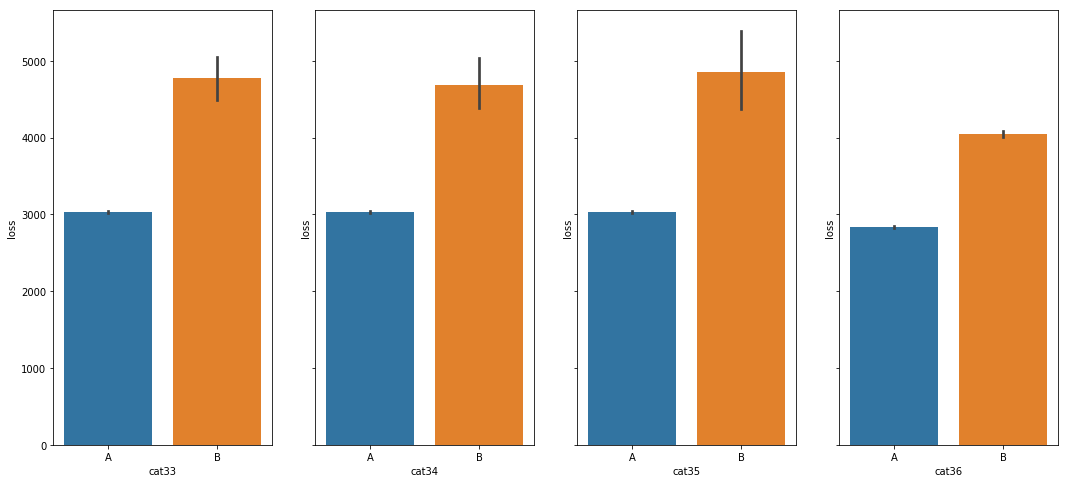

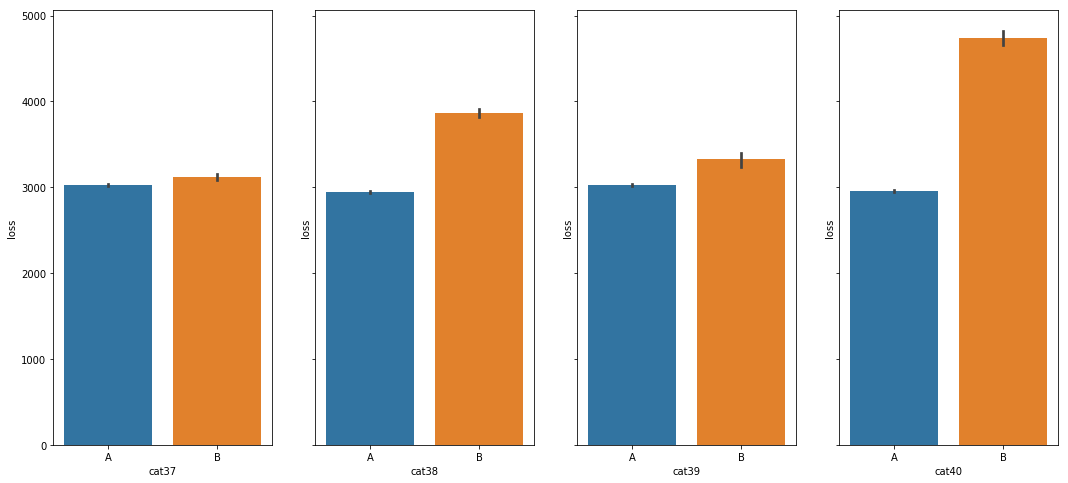

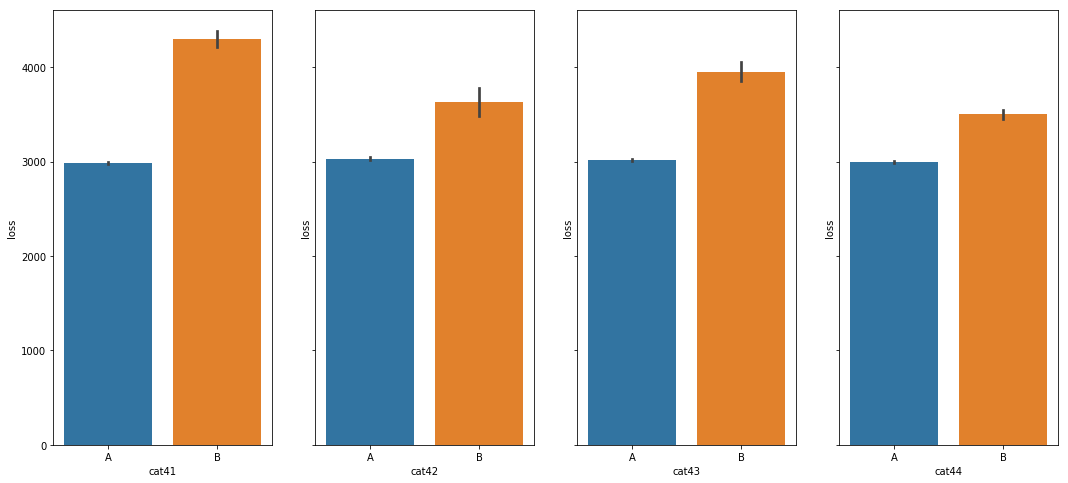

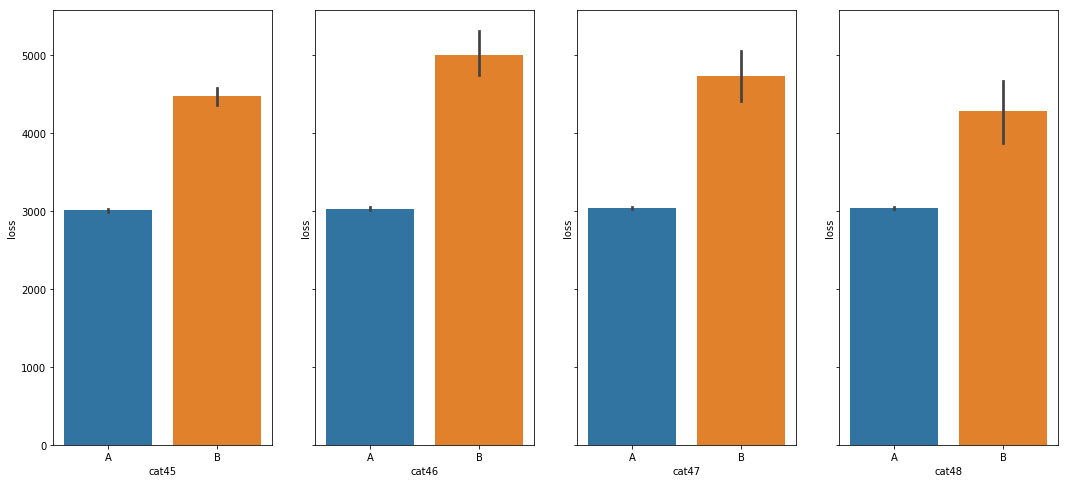

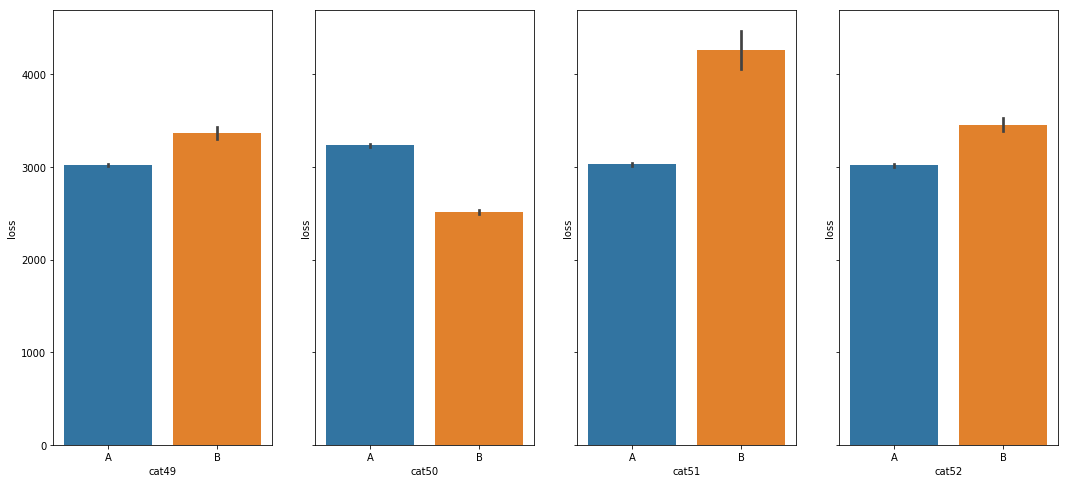

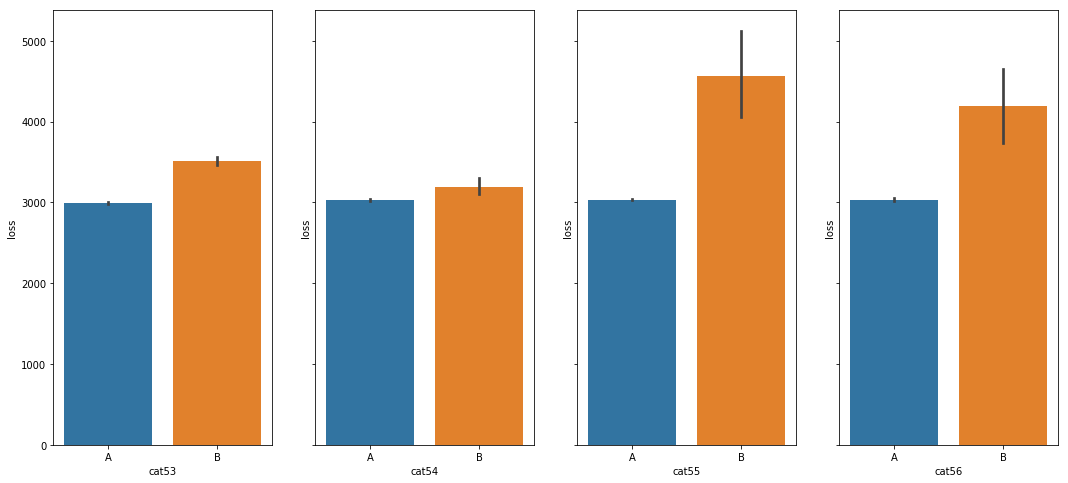

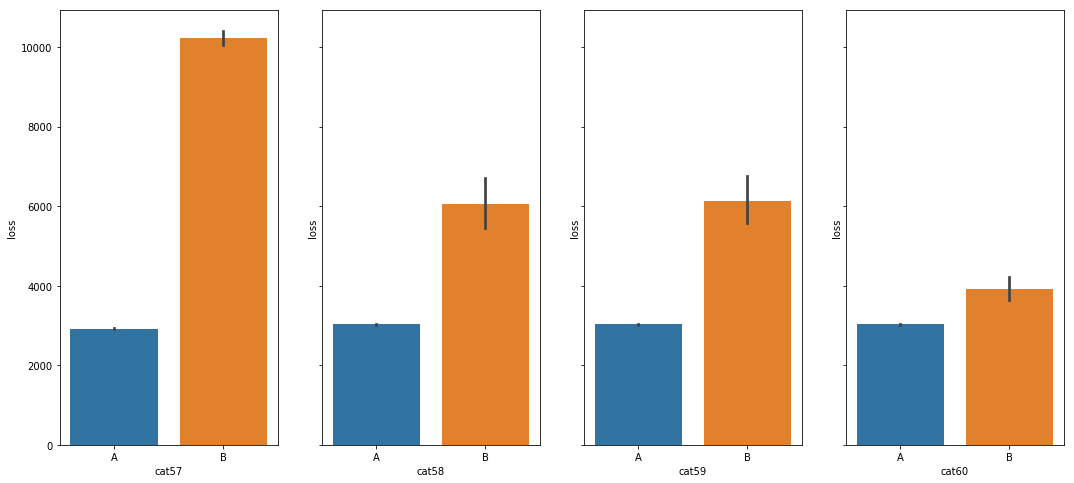

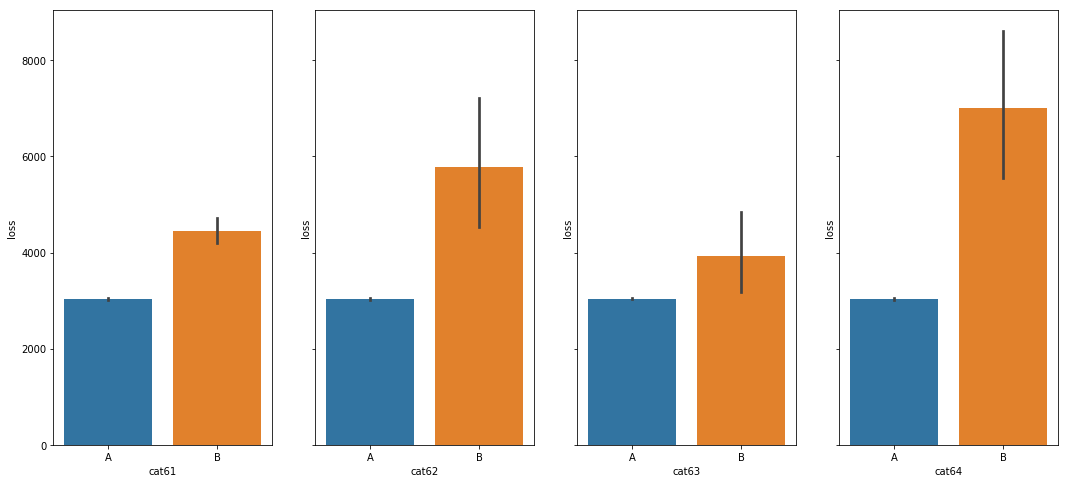

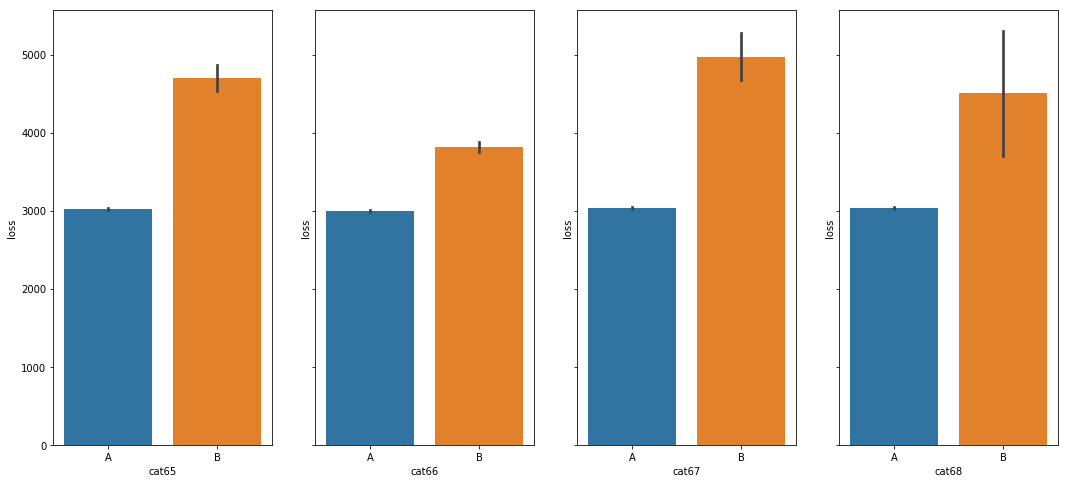

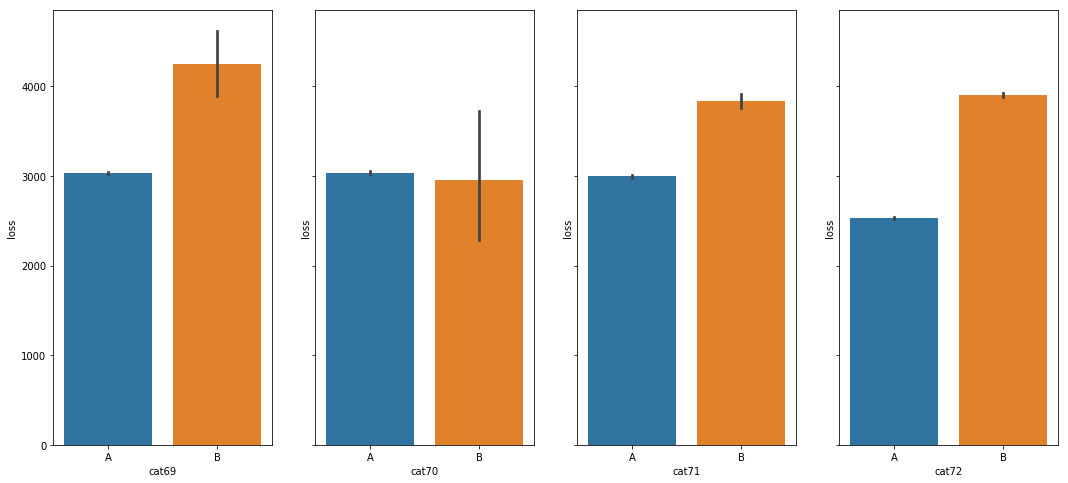

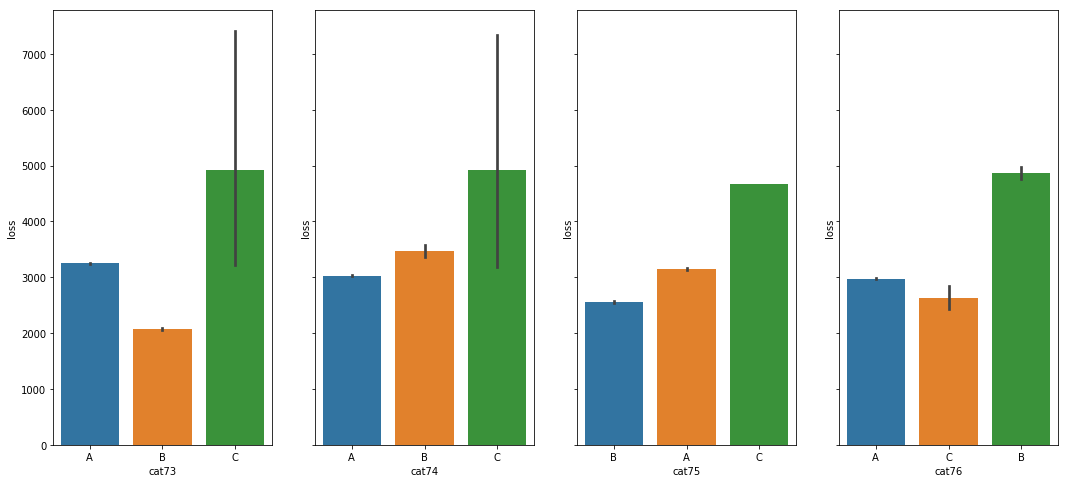

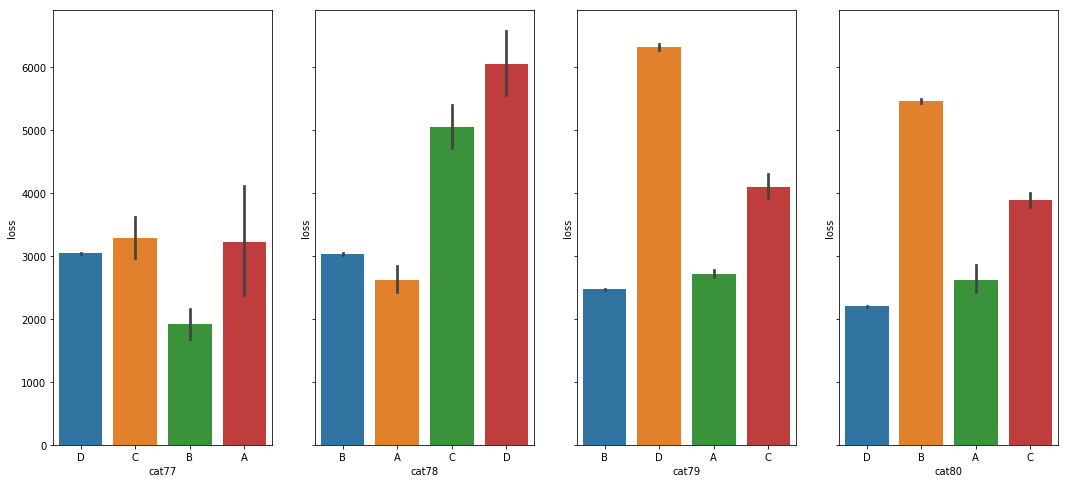

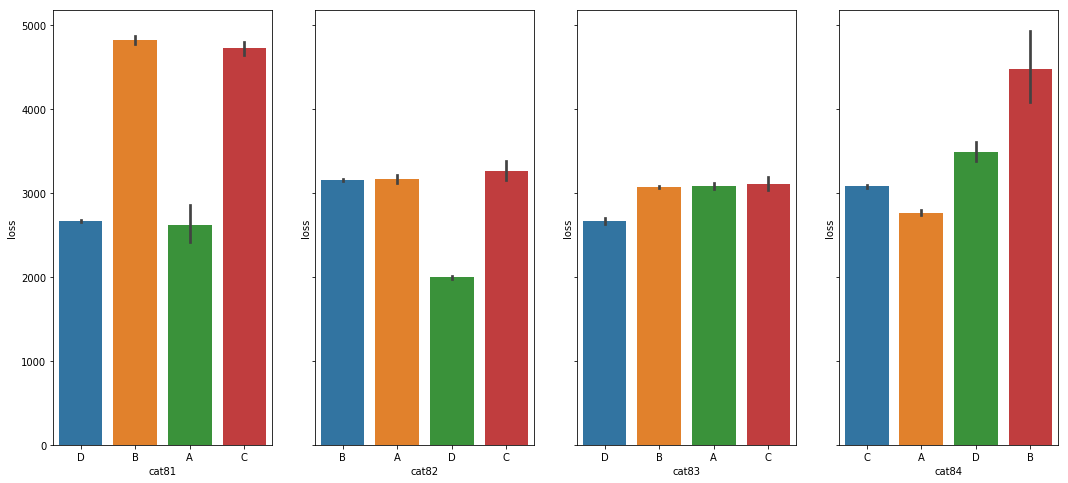

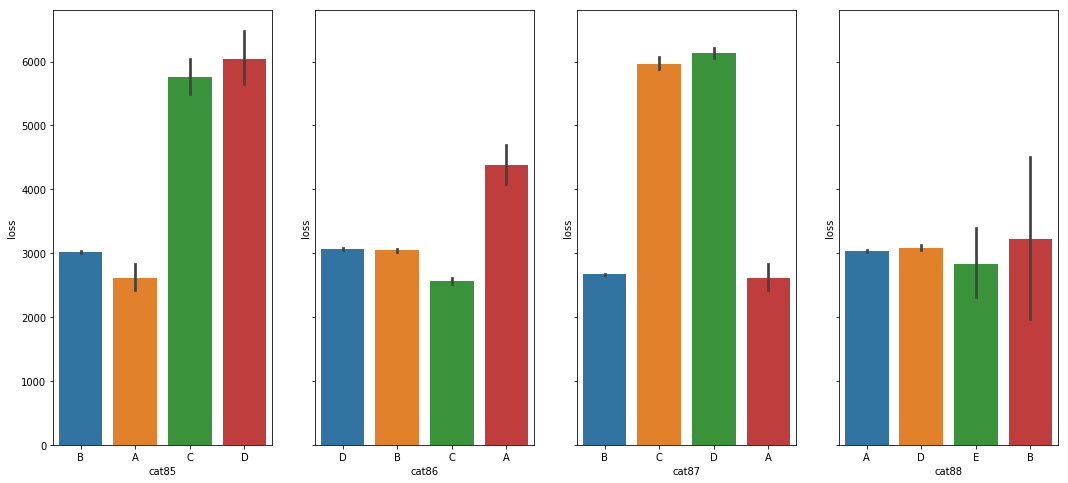

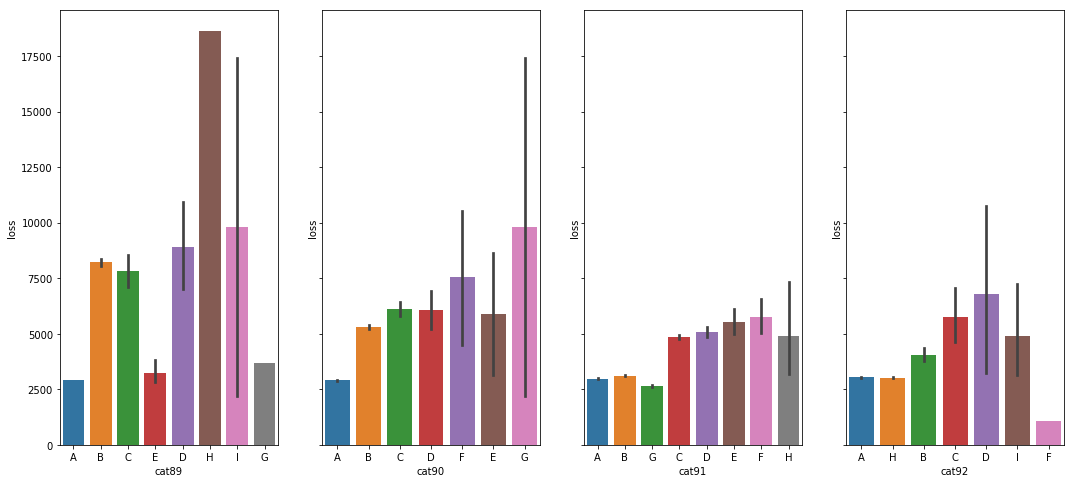

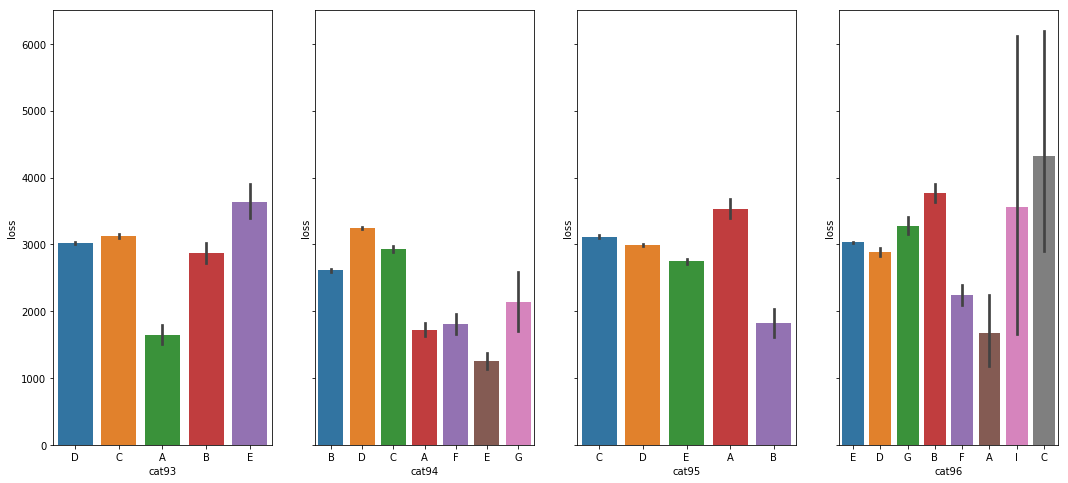

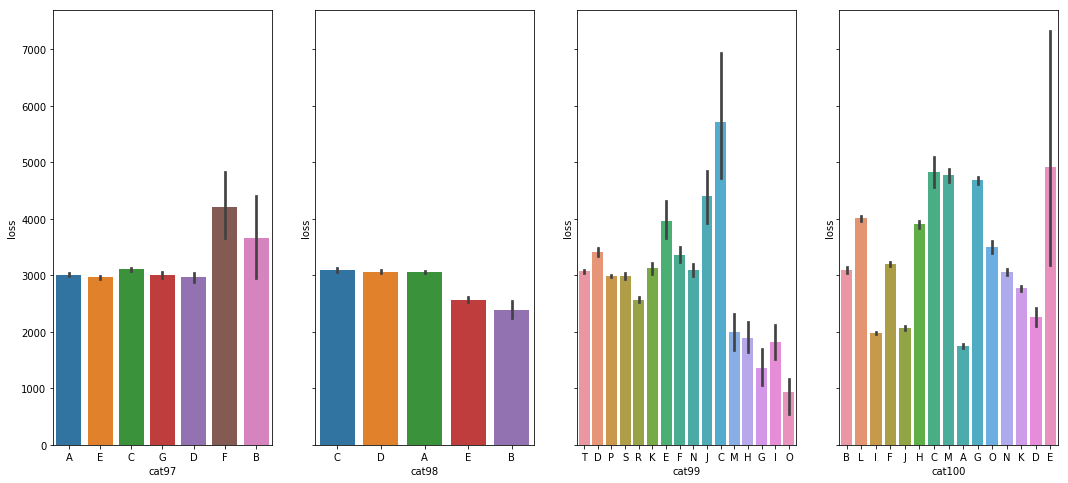

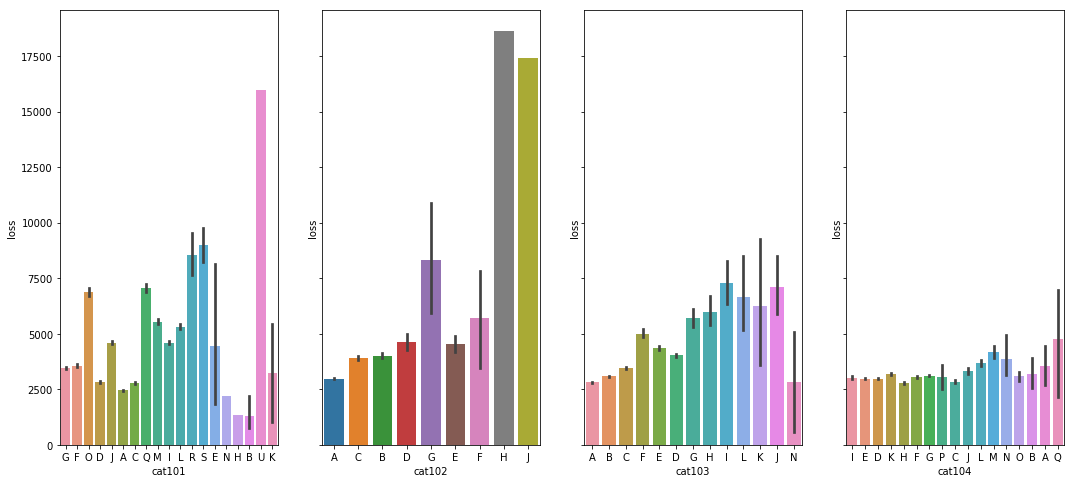

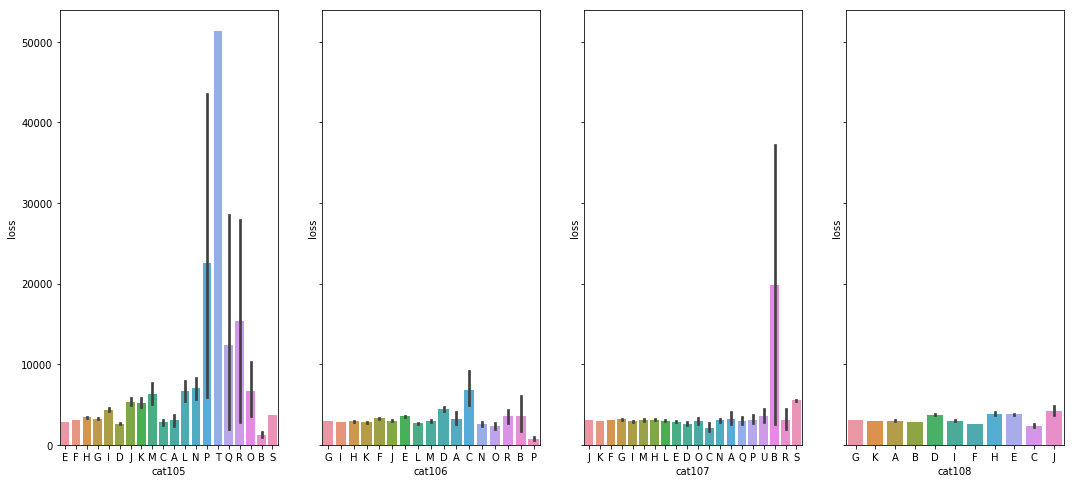

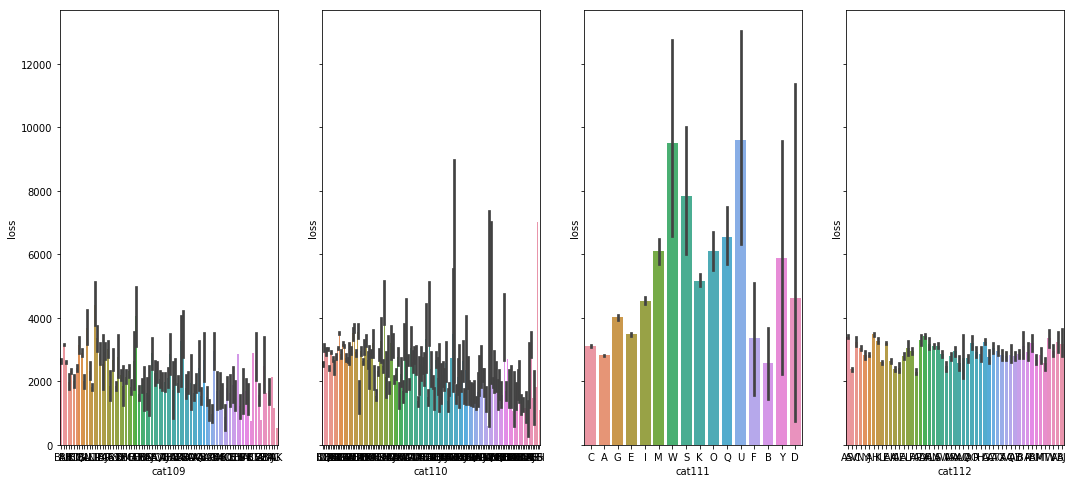

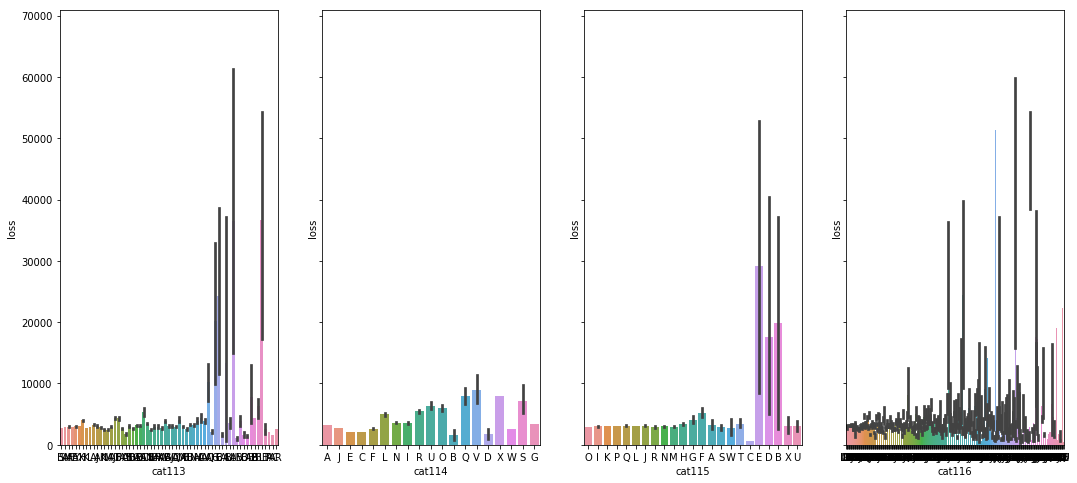

In [39]:
# 범주간 평균 loss값 시각화
cols = X[cat_columns].columns
n_cols = 4
n_rows = 29
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(18, 8))
    for j in range(n_cols):
        sns.barplot(x=cols[i*n_cols+j], y="loss", data=train, ax=ax[j])
        #sns.countplot(x=cols[i*n_cols+j], data=train, ax=ax[j])

### cat변수와 loss의 유의성(평균 차이) 검정
- 범주가 2개인 변수 -> t-test
- 범주가 3개인 변수 -> anova 검정

t-test, anova검정에서 유의확률 0.05이상인 변수는 제외
각 변수의 범주간 평균차가 2000이하 변수는 제외(변수 축소 및 loss와의 차이가 분명한 변수만 활용)

In [8]:
# cat 변수와 loss값에 유의미한 차이(평균의 차이)가 있는 변수만 설정
X_cat = X[cat_columns]
X_cat = pd.concat([X_cat, y], axis=1)

# 범주가 2개인 변수는 t-test, 3개 이상인 변수는 anova검정을 통해 유의미한 변수만 추출
mean_significant = []
for cat in X_cat.drop(columns=['loss']).columns :
    # 각 컬럼별 unique 갯수가 2면 t-test, 3이상이면 Anova분석으로 진행
    tmp_unique_len = len(X_cat[cat].unique())
    
    # t- test
    if tmp_unique_len == 2 :
        ttest_val = []
        
        for u_len in range(0,tmp_unique_len) :
            ttest_val.append(X_cat[cat].unique()[u_len])
            
        tmp_a = X_cat['loss'][X_cat[cat] == ttest_val[0]]
        tmp_b = X_cat['loss'][X_cat[cat] == ttest_val[1]]
        tmp_ttest_pValue = st.ttest_ind(tmp_a, tmp_b, equal_var=False)[1]
        if  tmp_ttest_pValue < 0.05 :
            mean_significant.append(cat)
            print(f'''{cat}의 p-value : {st.ttest_ind(tmp_a, tmp_b, equal_var=False)[1]}''')
        else :
            print(f'''{cat}의 p-value : {st.ttest_ind(tmp_a, tmp_b, equal_var=False)[1]} <- 변수 삭제''')
            
    
    # anova 검정
    else:
        anova_val = []
        
        for u_len in range(0,tmp_unique_len) :
            anova_val.append(X_cat[cat].unique()[u_len])
        
        tmp_anova_pValue = st.f_oneway(*(X_cat['loss'][X_cat[cat] == val] for val in anova_val))[1]
        if tmp_anova_pValue < 0.05 :
            mean_significant.append(cat)
            print(f'''{cat}의 p-value : {st.f_oneway(*(X_cat['loss'][X_cat[cat] == val] for val in anova_val))[1]}''')
        else :
            print(f'''{cat}의 p-value : {st.f_oneway(*(X_cat['loss'][X_cat[cat] == val] for val in anova_val))[1]}''')
            

X_cat = X_cat[mean_significant]
X_cat = pd.concat([X_cat, y], axis=1)

cat1의 p-value : 0.0
cat2의 p-value : 0.0
cat3의 p-value : 0.0
cat4의 p-value : 3.161642597045614e-273
cat5의 p-value : 2.9118896648546072e-300
cat6의 p-value : 0.0
cat7의 p-value : 0.0
cat8의 p-value : 7.881269795264977e-136
cat9의 p-value : 0.0
cat10의 p-value : 0.0
cat11의 p-value : 0.0
cat12의 p-value : 0.0
cat13의 p-value : 0.0
cat14의 p-value : 2.9167085846243297e-106
cat15의 p-value : 0.9547276548734009 <- 변수 삭제
cat16의 p-value : 0.0
cat17의 p-value : 1.6068716132699704e-65
cat18의 p-value : 9.129922099289426e-34
cat19의 p-value : 9.792353961528854e-27
cat20의 p-value : 9.069625829959119e-15
cat21의 p-value : 0.03445882390637919
cat22의 p-value : 0.14946081012308504 <- 변수 삭제
cat23의 p-value : 0.0
cat24의 p-value : 1.4934554524809153e-139
cat25의 p-value : 9.052498973147722e-171
cat26의 p-value : 5.6120627085222934e-65
cat27의 p-value : 0.010954260370403566
cat28의 p-value : 1.1852704626129445e-235
cat29의 p-value : 1.1780232892942057e-104
cat30의 p-value : 2.6926625291054713e-47
cat31의 p-value : 1.3455946342

In [88]:
X_cat.head(1)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat16,cat17,cat18,cat19,cat20,cat21,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat64,cat65,cat66,cat67,cat68,cat69,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,loss
0,3411.64,2458.28,2903.74,2836.14,2815.68,2519.28,2914.53,2980.75,2515.74,2695.63,2812.44,2658.09,2818.68,3008.68,2935.06,3020.26,3030.96,3029.85,3037.01,3039.36,2835.96,2990.03,2956.98,3004.31,3033.15,2968.24,3006.76,3020.41,3034.09,3035.31,3031.32,3035.34,3037.73,2833.98,3026.66,2946.27,3032.94,2962.64,2989.11,3035.5,3018.86,2996.48,3007.42,3030.77,3034.03,3038.31,3355.54,3234.57,3032.02,3021.76,3507.93,3036.93,3038.99,3039.16,2925.57,3036.25,3035.39,3038.05,3034.35,3039.49,3039.41,3020.64,3006.37,3032.84,3039.02,3038.24,2994.73,2522.77,2079.12,3031.52,3142.76,2980.71,3041.06,3029.21,2471.05,2203.96,2664.03,3151.45,3071.65,3077.85,3017.9,3048.55,2669.79,2914.53,2903.74,2975.32,3049.03,3022.53,3250.01,2755.74,2849.56,2975.04,3067.49,3012.77,1976.25,2458.28,2980.75,2815.68,2990.4,2869.46,2814.85,3095.47,3003.37,3148.82,3019.55,2836.14,3263.44,2897.64,2708.09,3010.43,2721.98,3927.97


<font color=blue>**cont 변수로 단순회귀 실행 RSME : '2841.35'을 기준으로 cat변수 수치화에 대한 성능평가**</font>

### (변수내) 범주간 loss평균으로 수치화
- **PCA 차원축소를 활용할 경우 성능이 가장 좋음**
    - Kmeans로 clustering 갯수 15개 이후 2200대 RMSE로 큰 감소 없음
    - PCA 차원축소 40 기준 RMSE: 2056.93으로 감소

In [99]:
# 범주를 각 평균값으로 설정
for cat in X_cat.drop(columns=['loss']).columns :
    tmp_unique_len = len(X_cat[cat].unique())
    for u_len in range(0,tmp_unique_len) :
        tmp_mean = round(X_cat[X_cat[cat] == X_cat[cat].unique()[u_len]].loss.mean(),2)
        X_cat[cat][X_cat[cat]==X_cat[cat].unique()[u_len]] = tmp_mean

In [56]:
# 값 설정 제대로 들어갔는지 확인
for col in X_cat.drop(columns='loss').columns :
    print(f'''X_cat[{col}]''')
    print(f'''unique1 : {round(X_cat[X_cat[f'{col}'] == X_cat[f'{col}'].unique()[0]].loss.mean(),2)}''')
    print(f'''unique2 : {round(X_cat[X_cat[f'{col}'] == X_cat[f'{col}'].unique()[1]].loss.mean(),2)}''')
    print(X_cat[f'{col}'].unique())
    print('---------------------------------------------------------------')

X_cat[cat1]
unique1 : 3411.64
unique2 : 1917.24
[3411.64 1917.24]
---------------------------------------------------------------
X_cat[cat2]
unique1 : 2458.28
unique2 : 3804.61
[2458.28 3804.61]
---------------------------------------------------------------
X_cat[cat3]
unique1 : 2903.74
unique2 : 5378.26
[2903.74 5378.26]
---------------------------------------------------------------
X_cat[cat4]
unique1 : 2836.14
unique2 : 3476.63
[2836.14 3476.63]
---------------------------------------------------------------
X_cat[cat5]
unique1 : 2815.68
unique2 : 3470.3
[2815.68 3470.3]
---------------------------------------------------------------
X_cat[cat6]
unique1 : 2519.28
unique2 : 3263.62
[2519.28 3263.62]
---------------------------------------------------------------
X_cat[cat7]
unique1 : 2914.53
unique2 : 8170.91
[2914.53 8170.91]
---------------------------------------------------------------
X_cat[cat8]
unique1 : 2980.75
unique2 : 3998.73
[2980.75 3998.73]
--------------------------

unique1 : 3032.84
unique2 : 5016.45
[3032.84 5016.45]
---------------------------------------------------------------
X_cat[cat68]
unique1 : 3039.02
unique2 : 4679.09
[3039.02 4679.09]
---------------------------------------------------------------
X_cat[cat69]
unique1 : 3038.24
unique2 : 4241.94
[3038.24 4241.94]
---------------------------------------------------------------
X_cat[cat71]
unique1 : 2994.73
unique2 : 3870.77
[2994.73 3870.77]
---------------------------------------------------------------
X_cat[cat72]
unique1 : 2522.77
unique2 : 3912.47
[2522.77 3912.47]
---------------------------------------------------------------
X_cat[cat73]
unique1 : 2079.12
unique2 : 3252.0
[2079.12 3252.0 4612.5]
---------------------------------------------------------------
X_cat[cat74]
unique1 : 3031.52
unique2 : 3475.04
[3031.52 3475.04 4612.5]
---------------------------------------------------------------
X_cat[cat75]
unique1 : 3142.76
unique2 : 2574.11
[3142.76 2574.11 4666.24]
---------

unique1 : 2836.14
unique2 : 5156.55
[2836.14 5156.55 3961.64 3494.21 3100.08 4567.69 5914.12 5890.72 11727.41
 8049.93 9385.68 7047.99 5891.66 2314.05 2501.97 1786.1]
---------------------------------------------------------------
X_cat[cat112]
unique1 : 3263.44
unique2 : 3097.81
[3263.44 3097.81 2380.31 3202.32 3330.69 2462.52 3049.37 3479.55 3442.42
 2366.28 2577.57 3415.43 2303.0 2825.23 3068.32 2629.55 2517.87 2844.94
 2803.4 3274.84 2907.16 2928.4 2715.48 2861.95 2851.78 3040.89 3216.67
 3221.64 3101.86 2952.26 2978.59 2765.44 2902.94 3279.38 2863.99 3210.29
 2767.82 2990.82 2465.36 2682.08 3206.84 2997.23 3069.46 2622.73 2906.09
 2694.55 3228.11 2787.77 2889.15 2702.35 3306.78]
---------------------------------------------------------------
X_cat[cat113]
unique1 : 2897.64
unique2 : 2755.13
[2897.64 2755.13 2766.42 3303.45 3029.51 3091.16 2878.8 3019.25 4408.07
 3108.38 3781.03 2926.93 3056.11 3963.56 11365.37 2932.38 4328.67 3263.26
 3097.37 2887.25 3146.58 3014.24 2637.7 4361.29

In [118]:
for n in (100, 500, 1000, 1500, 2000, 2500, 3000):
    print("===========================================================================")
    # maxMinusMin() 실행하려면 범주를 각 평균값으로 설정먼저 해야함!
    tmp_list = maxMinusMin(n)
    X_cat_dummy = X[tmp_list]
    X_cat_dummy = pd.get_dummies(X_cat_dummy, prefix=X_cat_dummy.columns)
    
    print(f'범주간 차이가 {n}이상인 변수만 활용하여 PCA변환 후 RMSE확인 (변수 {len(tmp_list)}개 dummy변환)')
    print('----------------------------------------------')
    pca_test = PCA(n_components=45)
    pca_test.fit(X_cat_dummy)
    for pca_n in [5, 10, 15, 20, 25, 30, 35, 40, 45] :
        print(f'pca_{pca_n} 성분(분산) 설명력: {round(np.cumsum(pca_test.explained_variance_ratio_)[pca_n-1],2)}')

    print('----------------------------------------------')
    # pca 주성분 갯수 별 RSME 출력
    pca_run(X_cat_dummy)

범주간 차이가 100이상인 변수만 활용하여 PCA변환 후 RMSE확인 (변수 110개 dummy변환)
----------------------------------------------
pca_5 성분(분산) 설명력: 0.27
pca_10 성분(분산) 설명력: 0.39
pca_15 성분(분산) 설명력: 0.46
pca_20 성분(분산) 설명력: 0.52
pca_25 성분(분산) 설명력: 0.56
pca_30 성분(분산) 설명력: 0.6
pca_35 성분(분산) 설명력: 0.63
pca_40 성분(분산) 설명력: 0.66
pca_45 성분(분산) 설명력: 0.68
----------------------------------------------
    pca_n    reg_train_result     reg_test_result
0   pca_3  2639.8260785354037  2635.6839126748337
1   pca_5   2623.694629668762   2621.401340198308
2  pca_10  2259.2070705955284   2277.390046430344
3  pca_15   2221.549351430256   2241.411958568002
4  pca_20  2203.2669130064232  2221.8279199782673
5  pca_25   2181.028760412073   2201.310718265645
6  pca_30  2173.4544931495484  2192.7574626060573
7  pca_35    2167.02646802626  2187.8022701763607
8  pca_40   2159.538293883503   2178.741355471785
9  pca_45  2150.7050732498965   2172.042860191633
범주간 차이가 500이상인 변수만 활용하여 PCA변환 후 RMSE확인 (변수 102개 dummy변환)
----------------------------

## cont변수 시각화 및 전처리

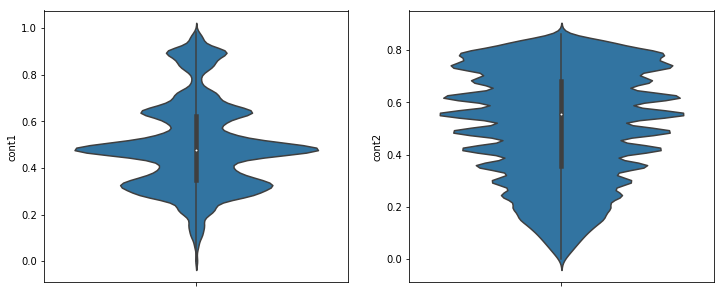

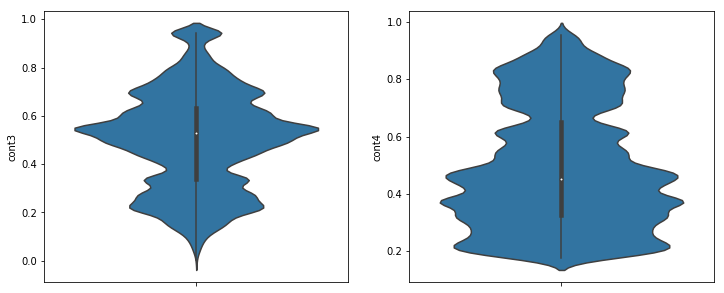

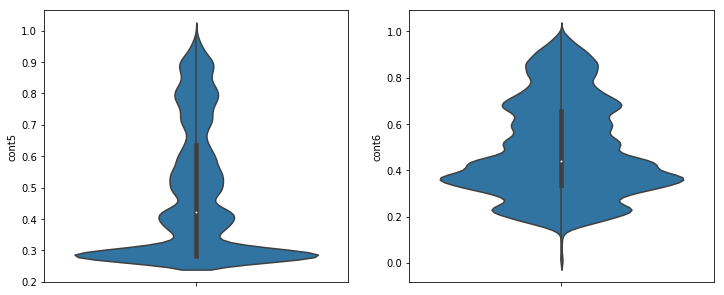

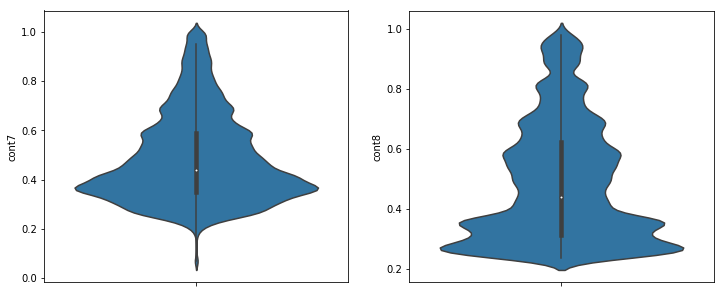

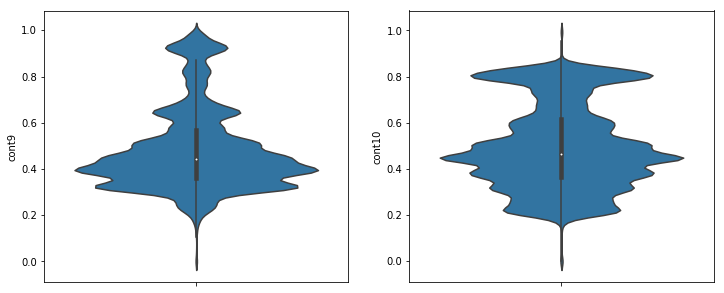

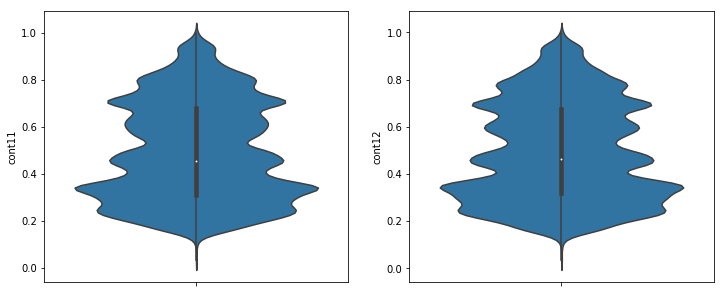

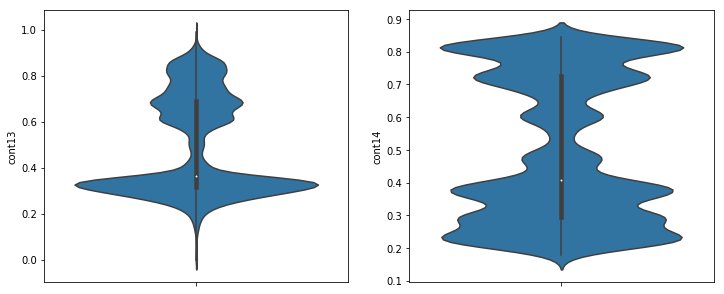

In [9]:
cols=X[cont_columns].columns 
n_cols = 2
n_rows = 7

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 5))
    for j in range(n_cols):
        sns.violinplot(cols[i*n_cols+j], data=X, ax=ax[j], orient='v')

In [22]:
round(X[cont_columns].corr(),2).style.background_gradient(cmap='coolwarm')

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
cont1,1,-0.09,-0.45,0.37,-0.03,0.76,0.37,0.36,0.93,0.81,0.6,0.61,0.53,0.06
cont2,-0.09,1,0.46,0.04,0.19,0.02,0.05,0.14,-0.03,0.06,0.12,0.11,0.02,-0.05
cont3,-0.45,0.46,1,-0.34,0.09,-0.35,0.1,-0.19,-0.42,-0.33,0.03,0.01,-0.42,-0.04
cont4,0.37,0.04,-0.34,1,0.16,0.22,-0.12,0.53,0.33,0.28,0.12,0.13,0.18,0.02
cont5,-0.03,0.19,0.09,0.16,1,-0.15,-0.25,0.01,-0.09,-0.06,-0.15,-0.15,-0.08,-0.02
cont6,0.76,0.02,-0.35,0.22,-0.15,1,0.66,0.44,0.8,0.88,0.77,0.79,0.82,0.04
cont7,0.37,0.05,0.1,-0.12,-0.25,0.66,1,0.14,0.38,0.49,0.75,0.74,0.29,0.02
cont8,0.36,0.14,-0.19,0.53,0.01,0.44,0.14,1,0.45,0.34,0.3,0.32,0.48,0.04
cont9,0.93,-0.03,-0.42,0.33,-0.09,0.8,0.38,0.45,1,0.79,0.61,0.63,0.64,0.07
cont10,0.81,0.06,-0.33,0.28,-0.06,0.88,0.49,0.34,0.79,1,0.7,0.71,0.71,0.04


### 선형회귀모델 p-value, VIF 확인

In [227]:
X_cont = X[cont_columns]
X_train, X_test, Y_train, Y_test = train_test_split(X_cont, y, test_size=0.3, random_state=5)
st_Reg(X_train, X_test, Y_train, Y_test)

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     391.2
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        05:09:23   Log-Likelihood:            -1.2356e+06
No. Observations:              131822   AIC:                         2.471e+06
Df Residuals:                  131807   BIC:                         2.471e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1473.6197     59.592     24.728      0.0

In [163]:
# p-value 0.05이상 변수 제거
X_cont = X[cont_columns]
X_cont = X_cont.drop(columns=['cont3','cont5'])
X_train, X_test, Y_train, Y_test = train_test_split(X_cont, y, test_size=0.3, random_state=5)
st_Reg(X_train, X_test, Y_train, Y_test)

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     456.2
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        04:17:46   Log-Likelihood:            -1.2356e+06
No. Observations:              131822   AIC:                         2.471e+06
Df Residuals:                  131809   BIC:                         2.471e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1488.5530     49.086     30.326      0.0

In [174]:
# p-value 0.05이상 변수 제거 + 다중공선성 높은 변수 제거
X_cont = X[cont_columns]
X_cont = X_cont.drop(columns=['cont3','cont5','cont1','cont11'])
X_train, X_test, Y_train, Y_test = train_test_split(X_cont, y, test_size=0.3, random_state=5)
st_Reg(X_train, X_test, Y_train, Y_test)

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     523.4
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        04:21:22   Log-Likelihood:            -1.2357e+06
No. Observations:              131822   AIC:                         2.471e+06
Df Residuals:                  131811   BIC:                         2.471e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1326.2330     47.806     27.742      0.0

In [35]:
# 최종 전저리 확인
X_cont = X[cont_columns]
X_cont_test = X_cont.drop(columns=['cont3','cont5','cont1','cont11'])

pca_test = PCA(n_components = 40)
X_pca_test = pca_test.fit_transform(X_cat_sqrt)
X_pca_test = pd.DataFrame(X_pca_test)

X_model_test = pd.concat([X_cont_test,X_pca_test], axis=1)
X_model_test.head(1)

,cont2,cont4,cont6,cont7,cont8,cont9,cont10,cont12,cont13,cont14,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.245921,0.789639,0.718367,0.33506,0.3026,0.67135,0.8351,0.594646,0.822493,0.714843,-1.280046,13.160399,-0.367867,-3.392666,-3.522741,-0.282169,-7.457926,1.535918,-11.053655,-3.85042,0.379238,-3.130977,-5.300908,-5.907404,8.158263,0.312633,-2.287543,-9.970237,-0.844211,3.449526,1.098505,3.054457,2.147687,-2.001241,1.232084,4.783569,-0.471001,-1.91492,0.11589,1.864248,0.275132,-0.525718,0.385178,0.223104,-0.159835,-0.823173,0.44746,-0.090174,1.896334,2.397157


In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X_model_test, y, test_size=0.3, random_state=5)
st_Reg(X_train, X_test, Y_train, Y_test)

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     2614.
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:43:48   Log-Likelihood:            -1.1928e+06
No. Observations:              131822   AIC:                         2.386e+06
Df Residuals:                  131771   BIC:                         2.386e+06
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1992.6566     44.373     44.907      0.0

In [46]:
X_model_test_v2 = X_model_test.drop(columns=[36,37])
X_train, X_test, Y_train, Y_test = train_test_split(X_model_test_v2, y, test_size=0.3, random_state=5)
st_Reg(X_train, X_test, Y_train, Y_test)

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     2723.
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:47:33   Log-Likelihood:            -1.1928e+06
No. Observations:              131822   AIC:                         2.386e+06
Df Residuals:                  131773   BIC:                         2.386e+06
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1997.8439     43.641     45.779      0.0

## loss 시각화
- loss에 로그를 취하고 전처리된 X변수와 성능평가(R^2 기준)진행하였으나 오히려 R^2 감소
- lof를 취하지 않은 원래 loss를 활용

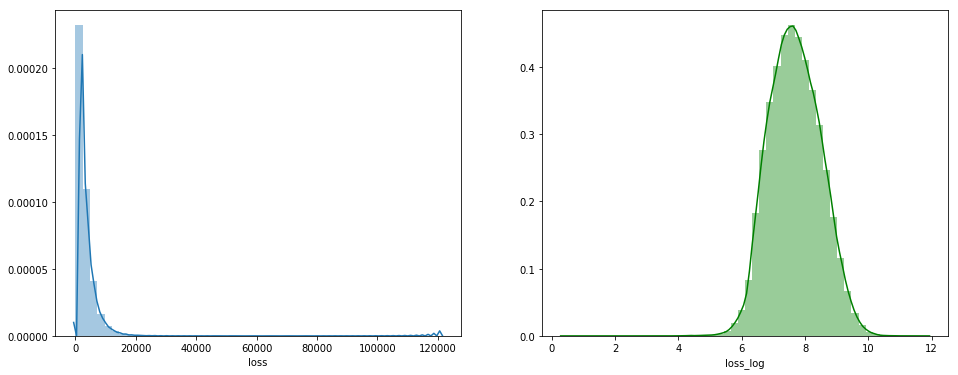

In [51]:
# loss가 좌편향되어 있어 log를 취함
train['loss_log'] = np.log1p(y)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 6)
sns.distplot(y, ax=ax1)
sns.distplot(train.loss_log, ax=ax2, color="green")
plt.show()

In [49]:
round(pd.concat([X[cont_columns],train['loss'], train['loss_log']], axis=1).corr(),2).style.background_gradient(cmap='coolwarm')

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss,loss_log,loss_robust
cont1,1,-0.09,-0.45,0.37,-0.03,0.76,0.37,0.36,0.93,0.81,0.6,0.61,0.53,0.06,-0.01,-0.01,-0.01
cont2,-0.09,1,0.46,0.04,0.19,0.02,0.05,0.14,-0.03,0.06,0.12,0.11,0.02,-0.05,0.14,0.1,0.14
cont3,-0.45,0.46,1,-0.34,0.09,-0.35,0.1,-0.19,-0.42,-0.33,0.03,0.01,-0.42,-0.04,0.11,0.08,0.11
cont4,0.37,0.04,-0.34,1,0.16,0.22,-0.12,0.53,0.33,0.28,0.12,0.13,0.18,0.02,-0.04,-0.03,-0.04
cont5,-0.03,0.19,0.09,0.16,1,-0.15,-0.25,0.01,-0.09,-0.06,-0.15,-0.15,-0.08,-0.02,-0.01,-0.01,-0.01
cont6,0.76,0.02,-0.35,0.22,-0.15,1,0.66,0.44,0.8,0.88,0.77,0.79,0.82,0.04,0.04,0.03,0.04
cont7,0.37,0.05,0.1,-0.12,-0.25,0.66,1,0.14,0.38,0.49,0.75,0.74,0.29,0.02,0.12,0.09,0.12
cont8,0.36,0.14,-0.19,0.53,0.01,0.44,0.14,1,0.45,0.34,0.3,0.32,0.48,0.04,0.03,0.03,0.03
cont9,0.93,-0.03,-0.42,0.33,-0.09,0.8,0.38,0.45,1,0.79,0.61,0.63,0.64,0.07,0.01,0.02,0.01
cont10,0.81,0.06,-0.33,0.28,-0.06,0.88,0.49,0.34,0.79,1,0.7,0.71,0.71,0.04,0.02,0.01,0.02


In [293]:
X_train, X_test, Y_train, Y_test = train_test_split(X_model_test, train['loss_log'], test_size=0.3, random_state=5)
st_Reg(X_train, X_test, Y_train, Y_test)

                            OLS Regression Results                            
Dep. Variable:               loss_log   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     2515.
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        05:31:33   Log-Likelihood:            -1.1506e+05
No. Observations:              131822   AIC:                         2.302e+05
Df Residuals:                  131771   BIC:                         2.307e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4064      0.012    594.534      0.0

# 모델링
## 랜덤포레스트

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_model_test_v2, y, test_size=0.3, random_state=5)

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators": [200, 500],
    "max_depth": [3, None],
    "max_features": [1, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False]}

model = RandomForestRegressor(random_state=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, Y_train)

print(grid.best_score_)
print(grid.best_params_)

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state=0, n_estimators=200, max_depth=None, max_features=3, 
                                  min_samples_leaf=1, min_samples_split=2, bootstrap=False)
regressor.fit(X_train, Y_train)